# EDA MTA Turnstiles

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
from pylab import rcParams
%matplotlib inline
rcParams['figure.figsize'] = 20,10
import numpy as np
import glob
from scipy import stats
import math

In [2]:
cd CSVs

/Users/jseemayer/Documents/Me/Metis/mta-project-1/CSVs


## Load Data

In [3]:
extension = 'txt'
all_filenames = [i for i in glob.glob('*.{}'.format(extension))]

#combine all files in the list
data = pd.concat([pd.read_csv(f) for f in all_filenames ])

## Clean Data

remove spaces from column names

In [4]:
data.columns = data.columns.str.replace(' ', '')

Add Date_Time column 

In [5]:
data['Date_Time'] = pd.to_datetime(data['DATE'], cache=True) + pd.to_timedelta(data['TIME'])

Add Turnstile (Combining SCP,C/A, Station and Unit) and Weekday column

In [6]:
data['Turnstile'] = data['C/A'] + data['UNIT'] + data['SCP'] + data['STATION']
data['DATE'] = pd.to_datetime(data['DATE'], cache=True)
data['Week_Day'] = data['DATE'].dt.day_name()

Only look at regular data

In [7]:
data = data[data.DESC == 'REGULAR']
data.head()

C/A  UNIT       SCP STATION LINENAME DIVISION       DATE      TIME  \
0  A002  R051  02-00-00   59 ST  NQR456W      BMT 2019-05-11  00:00:00   
1  A002  R051  02-00-00   59 ST  NQR456W      BMT 2019-05-11  04:00:00   
2  A002  R051  02-00-00   59 ST  NQR456W      BMT 2019-05-11  08:00:00   
3  A002  R051  02-00-00   59 ST  NQR456W      BMT 2019-05-11  12:00:00   
4  A002  R051  02-00-00   59 ST  NQR456W      BMT 2019-05-11  16:00:00   

      DESC  ENTRIES    EXITS           Date_Time              Turnstile  \
0  REGULAR  7053483  2390505 2019-05-11 00:00:00  A002R05102-00-0059 ST   
1  REGULAR  7053511  2390508 2019-05-11 04:00:00  A002R05102-00-0059 ST   
2  REGULAR  7053534  2390536 2019-05-11 08:00:00  A002R05102-00-0059 ST   
3  REGULAR  7053618  2390596 2019-05-11 12:00:00  A002R05102-00-0059 ST   
4  REGULAR  7053841  2390655 2019-05-11 16:00:00  A002R05102-00-0059 ST   

   Week_Day  
0  Saturday  
1  Saturday  
2  Saturday  
3  Saturday  
4  Saturday

### Find total traffic

Add shifted columns to show previous entries and exits

In [8]:
#All turnstiles have cumulative counts, previous data needs to be subtraced from current data 
#to find total entries/exits
grouped_time=data.copy()
grouped_time["PREV_TIME"] = data.groupby(["Turnstile"]).TIME.shift(1)
grouped_time["PREV_EXITS"] = data.groupby(["Turnstile"]).EXITS.shift(1)
grouped_time["PREV_ENTRIES"] = data.groupby(["Turnstile"]).ENTRIES.shift(1)
grouped_time.tail()

C/A  UNIT       SCP        STATION LINENAME DIVISION       DATE  \
206852  TRAM2  R469  00-05-01  RIT-ROOSEVELT        R      RIT 2019-05-03   
206853  TRAM2  R469  00-05-01  RIT-ROOSEVELT        R      RIT 2019-05-03   
206854  TRAM2  R469  00-05-01  RIT-ROOSEVELT        R      RIT 2019-05-03   
206855  TRAM2  R469  00-05-01  RIT-ROOSEVELT        R      RIT 2019-05-03   
206856  TRAM2  R469  00-05-01  RIT-ROOSEVELT        R      RIT 2019-05-03   

            TIME     DESC  ENTRIES  EXITS           Date_Time  \
206852  05:00:00  REGULAR     5554    376 2019-05-03 05:00:00   
206853  09:00:00  REGULAR     5554    376 2019-05-03 09:00:00   
206854  13:00:00  REGULAR     5554    376 2019-05-03 13:00:00   
206855  17:00:00  REGULAR     5554    376 2019-05-03 17:00:00   
206856  21:00:00  REGULAR     5554    376 2019-05-03 21:00:00   

                             Turnstile Week_Day PREV_TIME  PREV_EXITS  \
206852  TRAM2R46900-05-01RIT-ROOSEVELT   Friday  01:00:00       376.0   
206853  TRAM2R46900-05-01RIT-ROOSEVELT   Friday  05:00:00       376.0   
206854  TRAM2R46900-05-01RIT-ROOSEVELT   Friday  09:00:00       376.0   
206855  TRAM2R46900-05-01RIT-ROOSEVELT   Friday  13:00:00       376.0   
206856  TRAM2R46900-05-01RIT-ROOSEVELT   Friday  17:00:00       376.0   

        PREV_ENTRIES  
206852        5554.0  
206853        5554.0  
206854        5554.0  
206855        5554.0  
206856        5554.0

In [9]:
#drop first row of each turnstile b/c of shift down
grouped_time.dropna(subset=["PREV_ENTRIES"], axis=0, inplace=True)
grouped_time.head()

C/A  UNIT       SCP STATION LINENAME DIVISION       DATE      TIME  \
1  A002  R051  02-00-00   59 ST  NQR456W      BMT 2019-05-11  04:00:00   
2  A002  R051  02-00-00   59 ST  NQR456W      BMT 2019-05-11  08:00:00   
3  A002  R051  02-00-00   59 ST  NQR456W      BMT 2019-05-11  12:00:00   
4  A002  R051  02-00-00   59 ST  NQR456W      BMT 2019-05-11  16:00:00   
5  A002  R051  02-00-00   59 ST  NQR456W      BMT 2019-05-11  20:00:00   

      DESC  ENTRIES    EXITS           Date_Time              Turnstile  \
1  REGULAR  7053511  2390508 2019-05-11 04:00:00  A002R05102-00-0059 ST   
2  REGULAR  7053534  2390536 2019-05-11 08:00:00  A002R05102-00-0059 ST   
3  REGULAR  7053618  2390596 2019-05-11 12:00:00  A002R05102-00-0059 ST   
4  REGULAR  7053841  2390655 2019-05-11 16:00:00  A002R05102-00-0059 ST   
5  REGULAR  7054133  2390702 2019-05-11 20:00:00  A002R05102-00-0059 ST   

   Week_Day PREV_TIME  PREV_EXITS  PREV_ENTRIES  
1  Saturday  00:00:00   2390505.0     7053483.0  
2  Saturday  04:00:00   2390508.0     7053511.0  
3  Saturday  08:00:00   2390536.0     7053534.0  
4  Saturday  12:00:00   2390596.0     7053618.0  
5  Saturday  16:00:00   2390655.0     7053841.0

Remove counter errors from total entries/exits that occur from counters resetting (taken from mta_solns)

In [10]:
def get_daily_counts_exits(row, max_counter):
    counter_ex = row["EXITS"] - row["PREV_EXITS"]
    if counter_ex < 0:
        # Maybe counter is reversed?
        counter_ex = -counter_ex
    if counter_ex > max_counter:
        # Maybe counter was reset to 0? 
        #print(row["EXITS"], row["PREV_EXITS"])
        counter_ex = min(row["EXITS"], row["PREV_EXITS"])
    if counter_ex > max_counter:
        # Check it again to make sure we're not still giving a counter that's too big
        return 0
    return counter_ex

def get_daily_counts_entries(row, max_counter):
    counter_ent = row["ENTRIES"] - row["PREV_ENTRIES"]
    if counter_ent < 0:
        # Maybe counter is reversed?
        counter_ent = -counter_ent
    if counter_ent > max_counter:
        # Maybe counter was reset to 0? 
        #print(row["ENTRIES"], row["PREV_ENTRIES"])
        counter_ent = min(row["ENTRIES"], row["PREV_ENTRIES"])
    if counter_ent > max_counter:
        # Check it again to make sure we're not still giving a counter that's too big
        return 0
    return counter_ent


# If counter is > 1Million, then the counter might have been reset.  
# Just set it to zero as different counters have different cycle limits
# It'd probably be a good idea to use a number even significantly smaller than 1 million as the limit!

In [11]:
grouped_time["TOTAL_ENTRIES"] = grouped_time.apply(get_daily_counts_entries, axis=1, max_counter=100000)
grouped_time["TOTAL_EXITS"] = grouped_time.apply(get_daily_counts_exits, axis=1, max_counter=100000)
grouped_time.describe()

ENTRIES         EXITS    PREV_EXITS  PREV_ENTRIES  TOTAL_ENTRIES  \
count  2.236073e+06  2.236073e+06  2.236073e+06  2.236073e+06   2.236073e+06   
mean   4.148039e+07  3.396750e+07  3.396821e+07  4.148122e+07   6.120600e+02   
std    2.118498e+08  1.951475e+08  1.951484e+08  2.118507e+08   4.711624e+03   
min    0.000000e+00  0.000000e+00  0.000000e+00  0.000000e+00   0.000000e+00   
25%    3.499730e+05  1.430240e+05  1.430260e+05  3.499680e+05   1.000000e+01   
50%    2.176565e+06  1.254667e+06  1.254664e+06  2.176577e+06   7.600000e+01   
75%    6.780894e+06  4.604451e+06  4.604462e+06  6.780916e+06   2.520000e+02   
max    2.129395e+09  2.124196e+09  2.124196e+09  2.129395e+09   9.997500e+04   

        TOTAL_EXITS  
count  2.236073e+06  
mean   4.912548e+02  
std    4.015928e+03  
min    0.000000e+00  
25%    9.000000e+00  
50%    5.500000e+01  
75%    1.760000e+02  
max    9.999600e+04

In [12]:
#find total entries & exits after outliers are removed
grouped_time = grouped_time[(np.abs(stats.zscore(grouped_time["TOTAL_ENTRIES"])) < 3)] #filtering
grouped_time = grouped_time[(np.abs(stats.zscore(grouped_time["TOTAL_EXITS"])) < 3)] #filtering
grouped_time["TOTAL_TRAFFIC"] = grouped_time["TOTAL_EXITS"] + grouped_time["TOTAL_ENTRIES"]
grouped_time.head()

C/A  UNIT       SCP STATION LINENAME DIVISION       DATE      TIME  \
1  A002  R051  02-00-00   59 ST  NQR456W      BMT 2019-05-11  04:00:00   
2  A002  R051  02-00-00   59 ST  NQR456W      BMT 2019-05-11  08:00:00   
3  A002  R051  02-00-00   59 ST  NQR456W      BMT 2019-05-11  12:00:00   
4  A002  R051  02-00-00   59 ST  NQR456W      BMT 2019-05-11  16:00:00   
5  A002  R051  02-00-00   59 ST  NQR456W      BMT 2019-05-11  20:00:00   

      DESC  ENTRIES    EXITS           Date_Time              Turnstile  \
1  REGULAR  7053511  2390508 2019-05-11 04:00:00  A002R05102-00-0059 ST   
2  REGULAR  7053534  2390536 2019-05-11 08:00:00  A002R05102-00-0059 ST   
3  REGULAR  7053618  2390596 2019-05-11 12:00:00  A002R05102-00-0059 ST   
4  REGULAR  7053841  2390655 2019-05-11 16:00:00  A002R05102-00-0059 ST   
5  REGULAR  7054133  2390702 2019-05-11 20:00:00  A002R05102-00-0059 ST   

   Week_Day PREV_TIME  PREV_EXITS  PREV_ENTRIES  TOTAL_ENTRIES  TOTAL_EXITS  \
1  Saturday  00:00:00   2390505.0     7053483.0           28.0          3.0   
2  Saturday  04:00:00   2390508.0     7053511.0           23.0         28.0   
3  Saturday  08:00:00   2390536.0     7053534.0           84.0         60.0   
4  Saturday  12:00:00   2390596.0     7053618.0          223.0         59.0   
5  Saturday  16:00:00   2390655.0     7053841.0          292.0         47.0   

   TOTAL_TRAFFIC  
1           31.0  
2           51.0  
3          144.0  
4          282.0  
5          339.0

remove total traffic outliers that are 3 sigmas from mean

In [13]:
#find total traffic after outliers are removed
grouped_time = grouped_time[(np.abs(stats.zscore(grouped_time['TOTAL_TRAFFIC'])) < 3)] #filtering
grouped_time.describe()

ENTRIES         EXITS    PREV_EXITS  PREV_ENTRIES  TOTAL_ENTRIES  \
count  2.195987e+06  2.195987e+06  2.195987e+06  2.195987e+06   2.195987e+06   
mean   4.144654e+07  3.387481e+07  3.387640e+07  4.144980e+07   1.732468e+02   
std    2.117793e+08  1.948791e+08  1.948809e+08  2.117893e+08   2.461950e+02   
min    0.000000e+00  0.000000e+00  0.000000e+00  0.000000e+00   0.000000e+00   
25%    3.456595e+05  1.400750e+05  1.401150e+05  3.458320e+05   1.000000e+01   
50%    2.168043e+06  1.246084e+06  1.246272e+06  2.168239e+06   7.300000e+01   
75%    6.767464e+06  4.580796e+06  4.581009e+06  6.767599e+06   2.400000e+02   
max    2.129395e+09  2.124196e+09  2.124196e+09  2.129395e+09   2.294000e+03   

        TOTAL_EXITS  TOTAL_TRAFFIC  
count  2.195987e+06   2.195987e+06  
mean   1.344298e+02   3.076767e+02  
std    2.152466e+02   3.723806e+02  
min    0.000000e+00   0.000000e+00  
25%    8.000000e+00   2.900000e+01  
50%    5.200000e+01   1.710000e+02  
75%    1.660000e+02   4.550000e+02  
max    2.289000e+03   2.302000e+03

Drop uneeded columns

In [14]:
grouped_time.drop(['C/A','UNIT','SCP','LINENAME','DESC', 'ENTRIES', 'EXITS', 'PREV_TIME', 'PREV_ENTRIES', 'PREV_EXITS', 'TOTAL_ENTRIES', 'TOTAL_EXITS'], axis=1, inplace=True)

### Add Location and Income data

Load location data to get borough info and latitude/longitude information

In [15]:
loc_df = pd.read_csv('http://web.mta.info/developers/data/nyct/subway/Stations.csv')

In [16]:
#add borough_name column
burough_dict = { 'Q': 'Queens', 'M': 'Manhattan', 'Bk':'Brooklyn', 'Bx': 'Bronx', 'SI': 'Staten Island'}
loc_df['Borough_Name'] = loc_df['Borough'].map(burough_dict)

In [17]:
#drop uneeded columns
loc_df.drop(['Borough','Line','Station ID','Complex ID', 'GTFS Stop ID', 'Line', 'Structure', 
               'Daytime Routes', 'North Direction Label', 'South Direction Label', 'ADA', 'ADA Notes'], axis=1, inplace =True)

Rename columns in loc_data to merge on STATION and DIVISION

In [18]:
#stations were found to have the same name but located in different areas so DIVISION was also used
loc_df.rename(columns = {'Stop Name':'STATION', 'Division':'DIVISION','GTFS Latitude':'Latitude','GTFS Longitude':'Longitude'}, inplace = True) 
loc_df['STATION'] = loc_df['STATION'].str.upper()
#replace some strings in loc_df to match grouped_time station names
loc_df['STATION'] = loc_df['STATION'].str.replace('STATION', 'STA')
loc_df['STATION'] = loc_df['STATION'].str.replace('GRAND CENTRAL', 'GRD CNTRL')
loc_df['STATION'] = loc_df['STATION'].str.replace('42 ST-PORT AUTHORITY BUS TERMINAL', '42 ST-PORT AUTH')
#join with grouped_time
station_loc_df = grouped_time.merge(loc_df, how = 'inner', on = ['STATION'])

Add income data

In [19]:
#import income data
income_data = pd.read_csv('https://raw.githubusercontent.com/hollyyuqizheng/transportation-transformation/master/data/new_york/new%20york%20income%20data.csv')
#print(loc_data.Borough.unique())
#income_data.head()

In [20]:
#new df grouped by latitude, longitude, and station
station_lat_long_df = station_loc_df.groupby(['Latitude','Longitude', 'STATION','Borough_Name'], as_index=False ).TOTAL_TRAFFIC.sum()
station_lat_long_df.drop_duplicates('STATION',keep='first', inplace=True)

Find average income for each station

In [21]:
def find_min_dist(row):
    '''
    row from station_income_df as argument
    loop through income_df to find closest zip code based on latitude and longitude
    return Avg income of closest zip code to station
    '''
    min_dist = 1000
    idx = 0
    for index, r in income_data.iterrows():
        l = r[1].split(", ")
        l = [float(i) for i in l]
        a = ((l[0] - row['Latitude'])**2 + (l[1] - row['Longitude'])**2)
        a = abs(a)
        dist = math.sqrt(a)
        if dist < min_dist:
            min_dist = dist
            idx = index
    return income_data.iloc[idx]['Avg. Income/H/hold']

In [22]:
#new df that includes station income, location, and traffic info
station_income_df = station_lat_long_df.copy()
#apply function to find income info based on location, sort data by decreasing incomes
station_income_df['Avg_Income'] = station_income_df.apply(find_min_dist, axis=1) 
station_income_df.sort_values('Avg_Income', ascending=False, inplace=True)
#avg income in the thousands
station_income_df['Avg_Income'] = station_income_df['Avg_Income']/1000 
#print(station_income_df)

In [23]:
#find total income of all stations
total_income = station_income_df['Avg_Income'].sum()

New df with income and traffic data sorted by traffic

In [24]:
top_traffic_stations_df = station_income_df.copy()
top_traffic_stations_df = top_traffic_stations_df[['Borough_Name','STATION','Avg_Income', 'TOTAL_TRAFFIC']]
top_traffic_stations_df.sort_values('TOTAL_TRAFFIC', ascending=False, inplace=True)
#total traffic in the millions
top_traffic_stations_df['TOTAL_TRAFFIC'] = top_traffic_stations_df['TOTAL_TRAFFIC']/1000000

In [25]:
#find total traffic
total_traffic = top_traffic_stations_df['TOTAL_TRAFFIC'].sum()

New dfs for top 50 income and traffic, and income/traffic combined 

In [26]:
#find income and traffic percentiles by dividing income/traffic by total income/traffic across all stations
top50_income = station_income_df.head(50)
top50_income['Income_Percentile'] = (top50_income['Avg_Income']/total_income)*100

top50_traffic = top_traffic_stations_df.head(50)
top50_traffic['Traffic_Percentile'] = (top50_traffic['TOTAL_TRAFFIC']/total_traffic)*100

#drop uneeded columns before merging
top50_income.drop([ 'Avg_Income'], axis=1, inplace=True)
top50_traffic.drop([ 'Avg_Income'], axis=1, inplace=True)

<ipython-input-26-e128a9bde615>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  top50_income['Income_Percentile'] = (top50_income['Avg_Income']/total_income)*100
<ipython-input-26-e128a9bde615>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  top50_traffic['Traffic_Percentile'] = (top50_traffic['TOTAL_TRAFFIC']/total_traffic)*100
/Users/jseemayer/opt/anaconda3/lib/python3.8/site-packages/pandas/core/frame.py:4305: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

S

In [27]:
#new df containing stations in both the top 50 income and top 50 traffic
top_50_df = top50_income.merge(top50_traffic, how = 'inner', on = ['STATION', 'Borough_Name'])

#new total percentile col and sort df by decreasing total percentile
top_50_df['Total_Percentile'] = top_50_df['Traffic_Percentile'] + top_50_df['Income_Percentile']
top_50_df.sort_values('Total_Percentile', ascending=False, inplace=True)

In [28]:
#new df stations with containing top 10 total percentiles
top10_rank_df = top_50_df.head(10)

## Top Traffic Stations Based on Income and Traffic

### Top 10 Highest Trafffic Stations

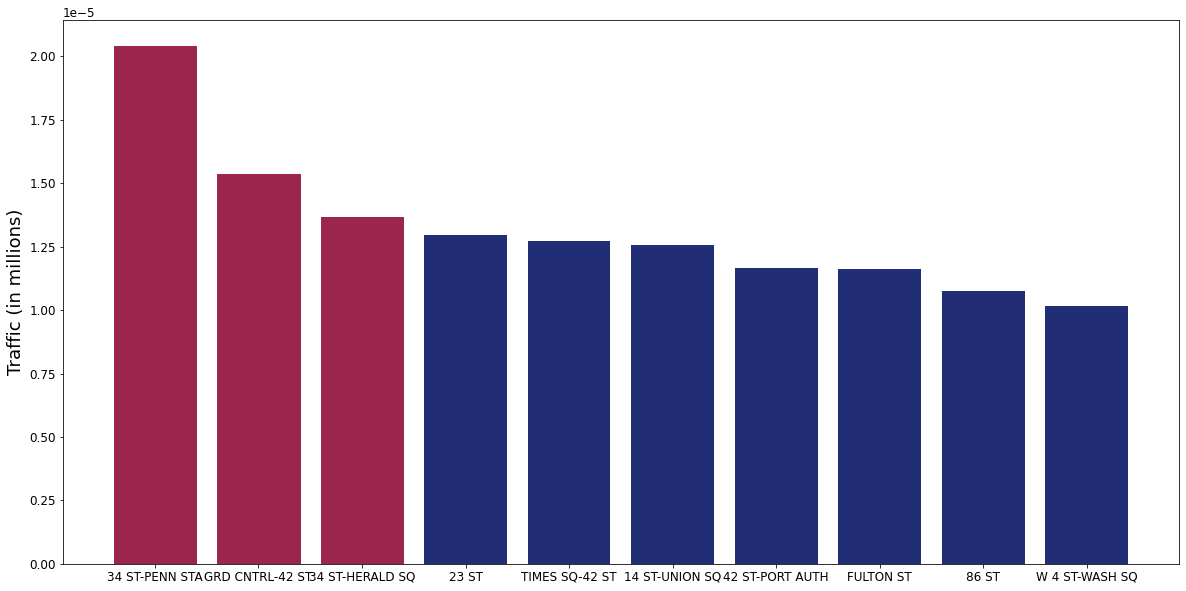

In [29]:
plt.rcParams['font.size']= 12
#only need top 10
top10_station_traffic_df = top_traffic_stations_df[['Borough_Name','STATION','Avg_Income', 'TOTAL_TRAFFIC']].head(10)

#income in thousands, traffic in millions
top10_station_traffic_df['Avg_Income'] = top10_station_traffic_df['Avg_Income']/1000
top10_station_traffic_df['TOTAL_TRAFFIC'] = top10_station_traffic_df['TOTAL_TRAFFIC']/1000000

#plot
top_traf_bar = plt.bar(top10_station_traffic_df['STATION'], top10_station_traffic_df['TOTAL_TRAFFIC'], color='#212d74')
plt.ylabel("Traffic (in millions)",fontsize=18)

#highlight stations in top 10 incomes and traffic
top_traf_bar[0].set_color('#9c254d')
top_traf_bar[1].set_color('#9c254d')
top_traf_bar[2].set_color('#9c254d')

#plt.savefig('top10_traf_bar.png', dpi=300)
plt.show()

### Top 10 Stations in Highest Income Areas

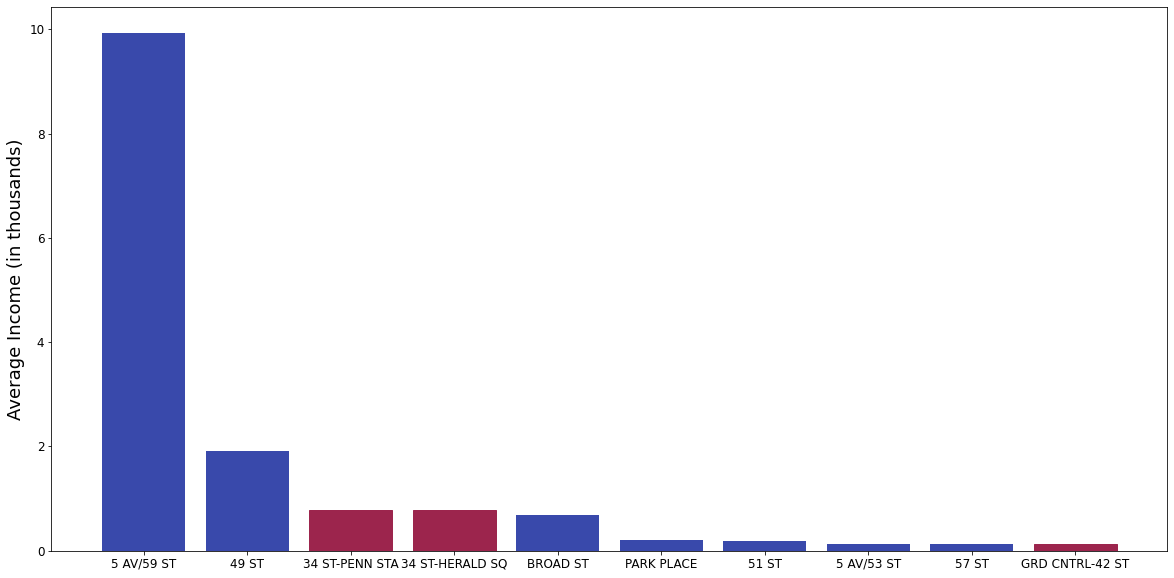

In [30]:
plt.rcParams['font.size']= 12
#only need top 10
top_station_income_df = station_income_df[['Borough_Name','STATION','Avg_Income', 'TOTAL_TRAFFIC']].head(10)

#income in thousands, traffic in millions
top_station_income_df['Avg_Income'] = top_station_income_df['Avg_Income']/1000
top_station_income_df['TOTAL_TRAFFIC'] = top_station_income_df['TOTAL_TRAFFIC']/1000000

#plot
top_inc_bar = plt.bar(top_station_income_df['STATION'], top_station_income_df['Avg_Income'], color='#3949ab')
plt.ylabel("Average Income (in thousands)",fontsize=18)

#highlight stations in top 10 incomes and traffic
top_inc_bar[3].set_color('#9c254d')
top_inc_bar[2].set_color('#9c254d')
top_inc_bar[9].set_color('#9c254d')

#plt.savefig('top10_inc_bar.png', dpi=300)
plt.show()

### Top 10 stations for both Income and Traffic 

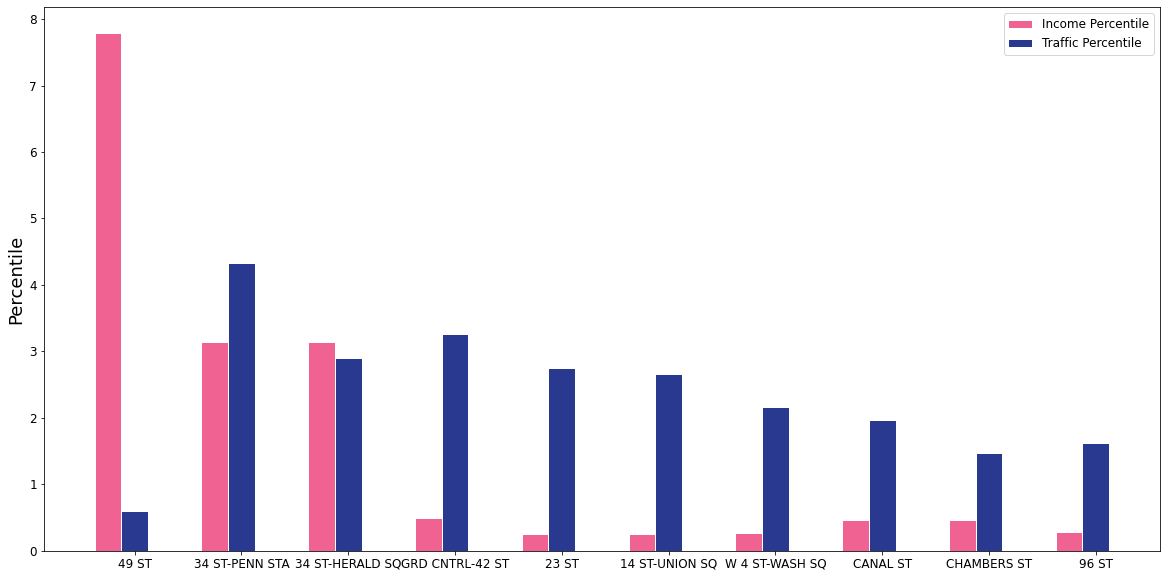

In [31]:
barWidth = 0.25
r1 = np.arange(len(top10_rank_df['STATION']))
r2 = [x + barWidth for x in r1]
 
# Make the plot
plt.bar(r1,top10_rank_df['Income_Percentile'], color= '#f06292', width=barWidth, edgecolor='white', label='Income Percentile')
plt.bar(r2, top10_rank_df['Traffic_Percentile'], color='#2a3990', width=barWidth, edgecolor='white', label='Traffic Percentile')

# Add xticks on the middle of the group bars
plt.xticks([r + barWidth for r in range(len(top10_rank_df['Traffic_Percentile']))], top10_rank_df['STATION'])
 
plt.rcParams['font.size']= 12
plt.ylabel("Percentile",fontsize=18)
plt.legend()
plt.show()

## Compare Boroughs (Further Outreach Later)

### Graph number of stations in each borough

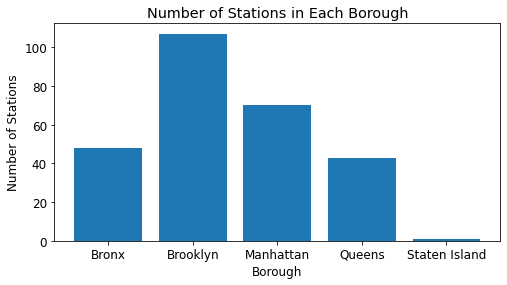

In [32]:
borough_station_count_df = station_loc_df.groupby('Borough_Name')['STATION'].nunique().reset_index()
plt.rcParams["figure.figsize"] = (8, 4)
plt.xlabel("Borough")
plt.ylabel("Number of Stations")
plt.title("Number of Stations in Each Borough")
plt.bar(borough_station_count_df['Borough_Name'], borough_station_count_df['STATION']);

### Graph total traffic in each Borough 

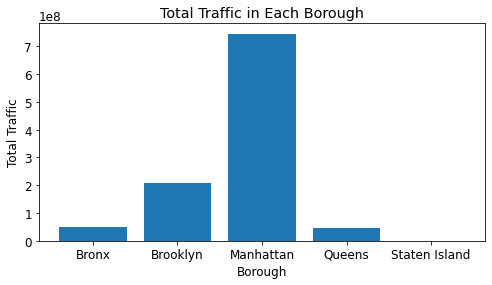

In [33]:
borough_traffic_df = station_loc_df.groupby('Borough_Name').TOTAL_TRAFFIC.sum().reset_index()
plt.xlabel("Borough")
plt.ylabel("Total Traffic")
plt.title("Total Traffic in Each Borough")
plt.bar(borough_traffic_df['Borough_Name'], borough_traffic_df['TOTAL_TRAFFIC']);

### Find top 5 stations in each borough and graph

In [34]:
#new df with top 5 in each borough by traffic sorted
borough_top5_df = station_loc_df.groupby(['Borough_Name','STATION']).agg({'TOTAL_TRAFFIC':'sum'}, asindex=False)
borough_top5_df = borough_top5_df['TOTAL_TRAFFIC'].groupby('Borough_Name', group_keys=False)
borough_top5_df = borough_top5_df.apply(lambda x: x.sort_values(ascending=False).head(5))
borough_top5_df

Borough_Name   STATION        
Bronx          FORDHAM RD          4094810.0
               167 ST              4036632.0
               KINGSBRIDGE RD      3711848.0
               170 ST              3312638.0
               GUN HILL RD         3177424.0
Brooklyn       86 ST              21506230.0
               CHURCH AV          12697413.0
               FULTON ST          11633385.0
               KINGS HWY          10373988.0
               7 AV               10061578.0
Manhattan      23 ST              64750730.0
               CANAL ST           55577538.0
               TIMES SQ-42 ST     50962096.0
               FULTON ST          46533540.0
               GRD CNTRL-42 ST    46119555.0
Queens         WOODHAVEN BLVD      5160276.0
               COURT SQ            4677192.0
               111 ST              4671708.0
               JUNCTION BLVD       2747250.0
               36 ST               2041323.0
Staten Island  TOMPKINSVILLE         66785.0
Name: TOTAL_TRAFFIC, dty

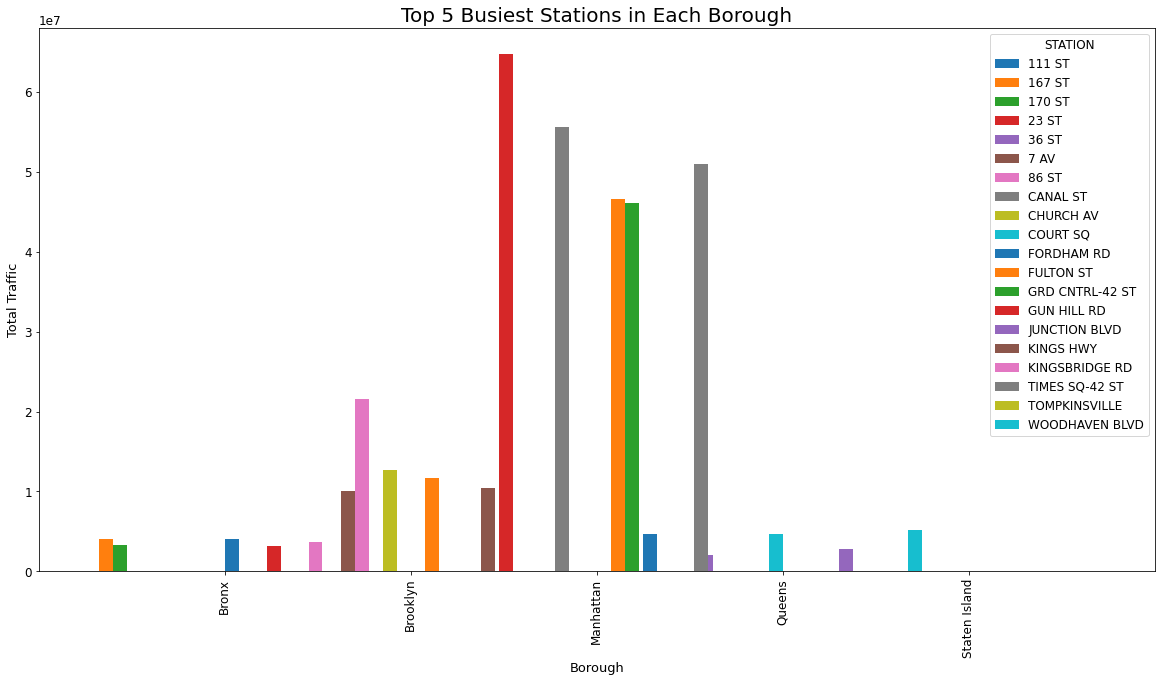

In [35]:
rcParams['figure.figsize'] = 20,10
borough_top5_df.unstack().plot.bar(width=1.5)
plt.title("Top 5 Busiest Stations in Each Borough", fontsize=20)
plt.ylabel("Total Traffic",fontsize=13)
plt.xlabel("Borough",fontsize=13)
plt.rcParams.update({'font.size': 9})

### Find high traffic days

In [36]:
#find max and min of lat and long
BBox = (station_lat_long_df.Longitude.min(),   station_lat_long_df.Longitude.max(),      
         station_lat_long_df.Latitude.min(), station_lat_long_df.Latitude.max())
BBox

(-74.074835, -73.761353, 40.576312, 40.898379)

In [37]:
cd - 

/Users/jseemayer/Documents/Me/Metis/mta-project-1


In [38]:
ruh_m = plt.imread('NYC_Map.png') #load NYC Map

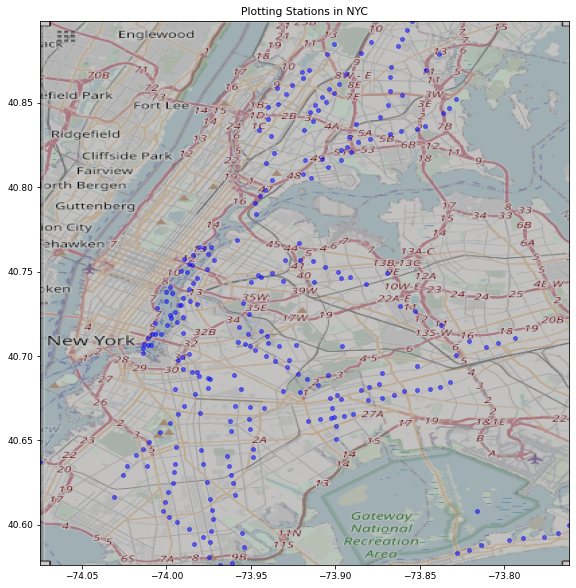

In [39]:
fig, ax = plt.subplots(figsize = (11,10))
ax.scatter(station_lat_long_df.Longitude, station_lat_long_df.Latitude, 
           zorder=1, alpha= 0.5, c='b', s=15)
ax.set_title('Plotting Stations in NYC')
ax.set_xlim(BBox[0],BBox[1])
ax.set_ylim(BBox[2],BBox[3])
ax.imshow(ruh_m, zorder=0, extent = BBox, aspect= 'equal');

Need a new map that overlays with stations more accurately

### Find high traffic days

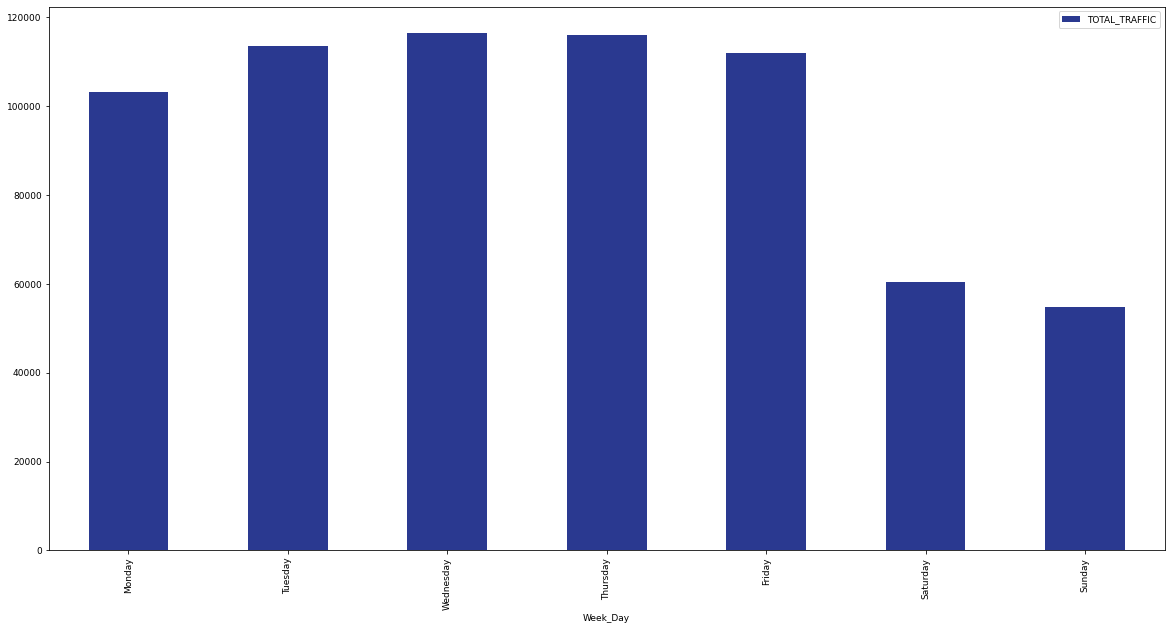

In [40]:
#Group days of the week in logical order
Total_Weekly_ridership = grouped_time.groupby(['Week_Day']).TOTAL_TRAFFIC.sum().reset_index()
Total_Weekly_ridership.columns = ['Week_Day','TOTAL_TRAFFIC']
days = ['Monday','Tuesday','Wednesday','Thursday','Friday','Saturday', 'Sunday']
mapping = {day: i for i, day in enumerate(days)}
key = Total_Weekly_ridership['Week_Day'].map(mapping)
Total_Weekly_ridership = Total_Weekly_ridership.iloc[key.argsort()].set_index('Week_Day')
#sanity check
##list(Total_Weekly_ridership.columns)
my_colors = ['#2a3990','#2a3990','#2a3990','#2a3990','#2a3990','#f06292','#f06292']
Total_Weekly_ridership['TOTAL_TRAFFIC'] = Total_Weekly_ridership['TOTAL_TRAFFIC']//1000
Total_Weekly_ridership.plot(kind = 'bar',color = my_colors);

Based on this it seems like Total weekend traffic is much more compared to the weekday - **So WTWY should focus on weekdays more**

## Top 5 Busiest Stations Daily Traffic Trends

In [41]:
Total_ridership = grouped_time.groupby(['STATION']).TOTAL_TRAFFIC.sum().reset_index()
Total_ridership.sort_values(by=['TOTAL_TRAFFIC'],inplace = True, ascending = False)
Total_ridership.head()

STATION  TOTAL_TRAFFIC
61    34 ST-PENN STA     20408482.0
232  GRD CNTRL-42 ST     15373185.0
59   34 ST-HERALD SQ     13674461.0
46             23 ST     12950146.0
352   TIMES SQ-42 ST     12740524.0

In [42]:
Top5 = top10_station_traffic_df['STATION'][0:5].tolist()
Top5
Top5_stations = grouped_time[grouped_time['STATION'].isin(Top5)]
Top5_station_weekly = Top5_stations.groupby(['STATION','Week_Day']).TOTAL_TRAFFIC.sum().reset_index()
Top5_station_Daily = Top5_stations.groupby(['STATION','DATE']).TOTAL_TRAFFIC.sum().reset_index()

### Weekly plot for Top 5 Stations

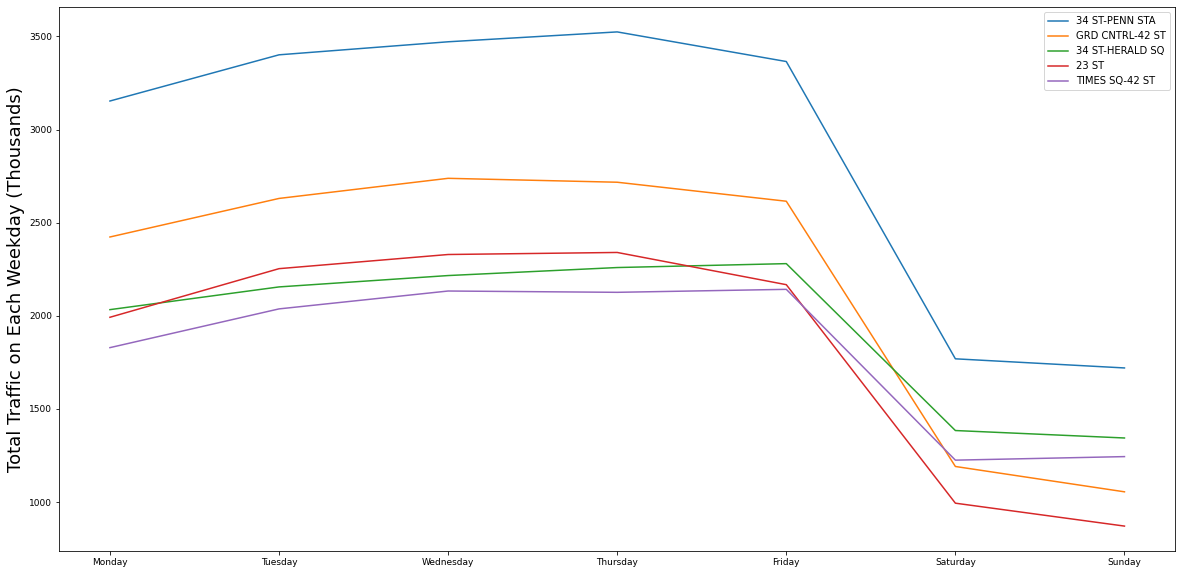

In [43]:
timeaxis_list = ["Monday", "Tuesday", "Wednesday", "Thursday", "Friday", "Saturday", "Sunday"]
for stations in Top5:
    station = Top5_station_weekly[Top5_station_weekly['STATION'] == stations]
    station = station.set_index('Week_Day').loc[timeaxis_list]
    plt.plot(station['TOTAL_TRAFFIC']//1000,label = stations)
plt.ylabel("Total Traffic on Each Weekday (Thousands)",fontsize=18)
#plt.title("Weekly Traffic for Top5 busiest stations",fontsize=27)
plt.rcParams.update({'font.size': 10})
plt.savefig('top5_weekly_traffic.png', dpi=300)
plt.legend()
plt.show()

This plot also corroborated the results from combined stations results that weekends show a dip

### Daily Traffic for Top 5

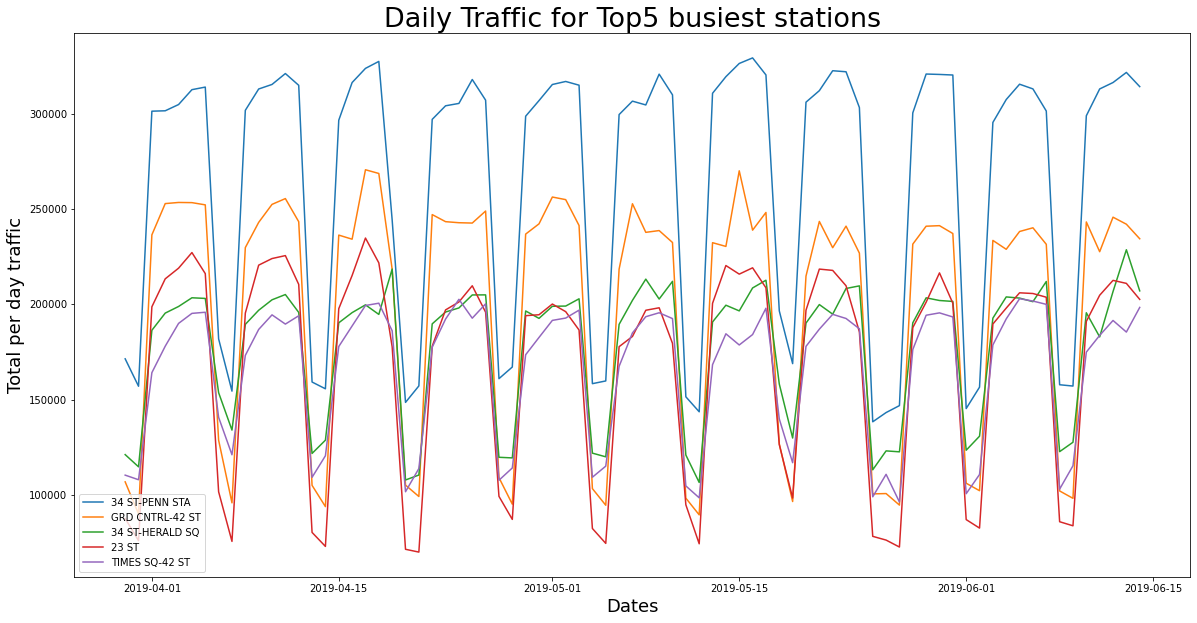

In [44]:
for stations in Top5:
    station = Top5_station_Daily[Top5_station_Daily['STATION'] == stations]
    plt.plot(station['DATE'],station['TOTAL_TRAFFIC'],label = stations)
plt.xlabel("Dates", fontsize=18)
plt.ylabel("Total per day traffic",fontsize=18)
plt.title("Daily Traffic for Top5 busiest stations",fontsize=27)
plt.rcParams.update({'font.size': 10})
plt.savefig('top5_daily_traffic.png', dpi=300)
plt.legend()
plt.show()

## Find Peak Hours

In [45]:
Top10 = top10_station_traffic_df['STATION'][0:10].tolist()
Top10_stations = grouped_time[grouped_time['STATION'].isin(Top10)]
Top10_station_hourly = Top10_stations.groupby(['STATION','TIME']).TOTAL_TRAFFIC.sum().reset_index()
Top10_station_hourly.head()

STATION      TIME  TOTAL_TRAFFIC
0  14 ST-UNION SQ  01:00:00      1155702.0
1  14 ST-UNION SQ  05:00:00       161086.0
2  14 ST-UNION SQ  07:28:40         3613.0
3  14 ST-UNION SQ  07:36:05          645.0
4  14 ST-UNION SQ  08:11:07         6078.0

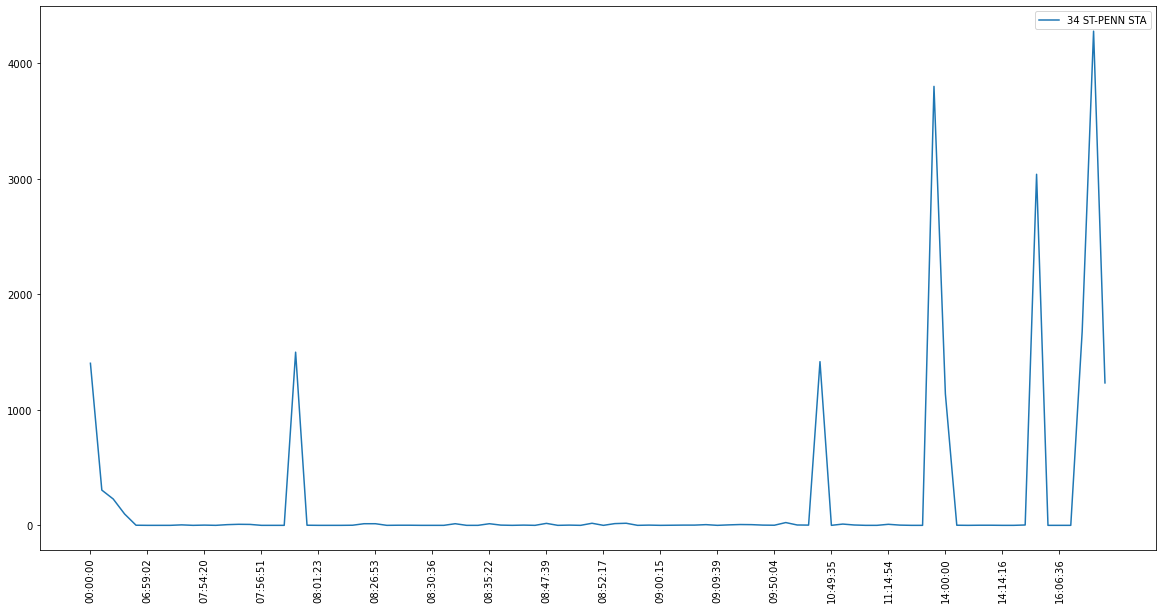

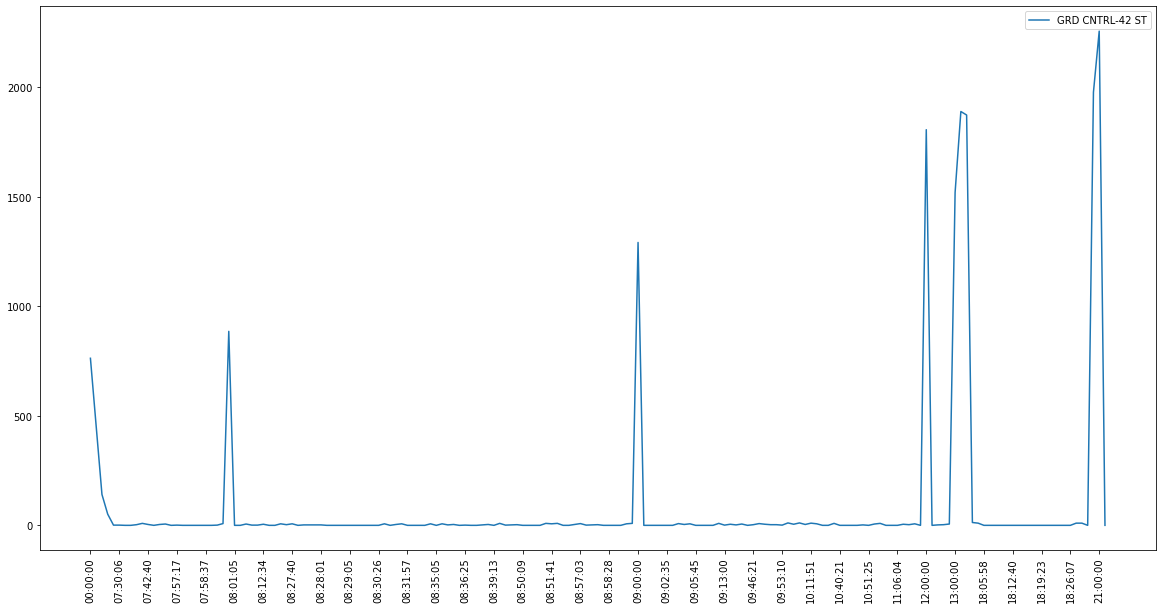

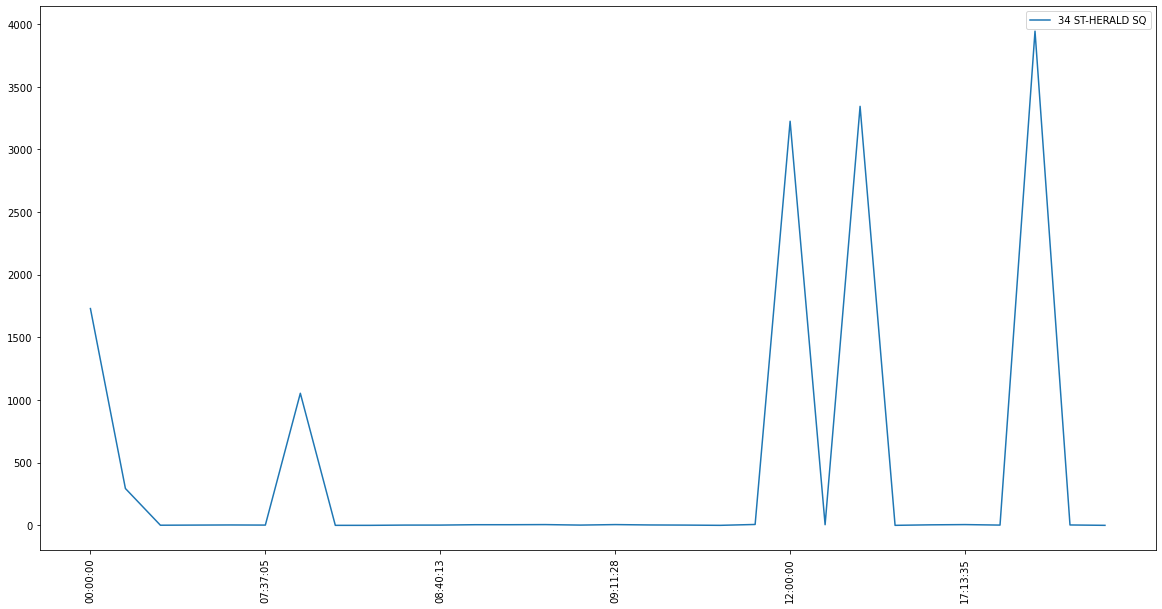

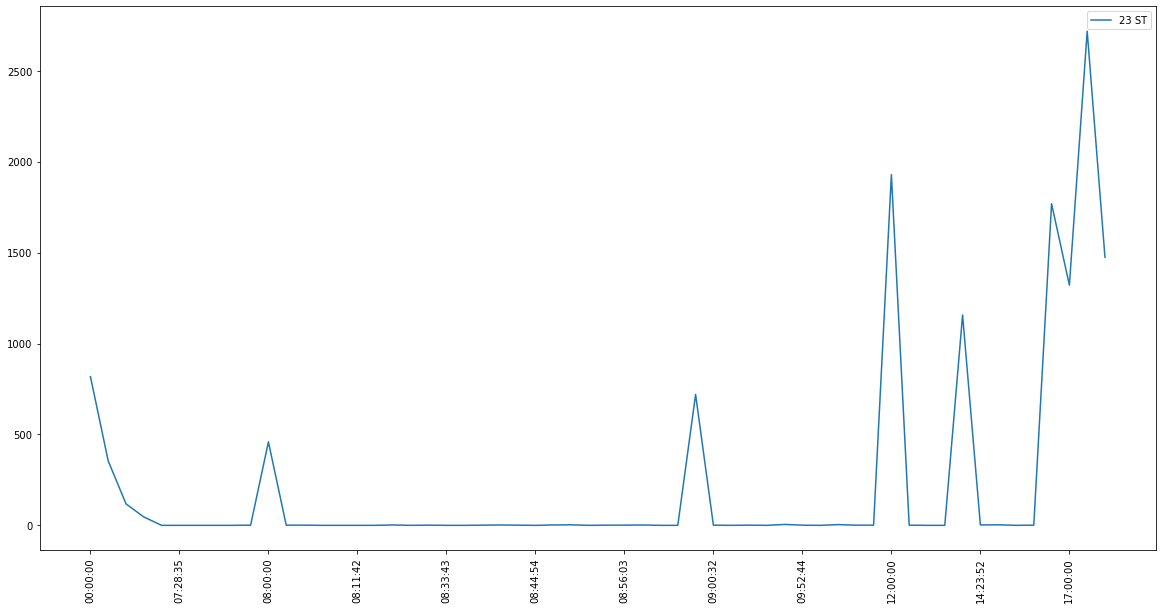

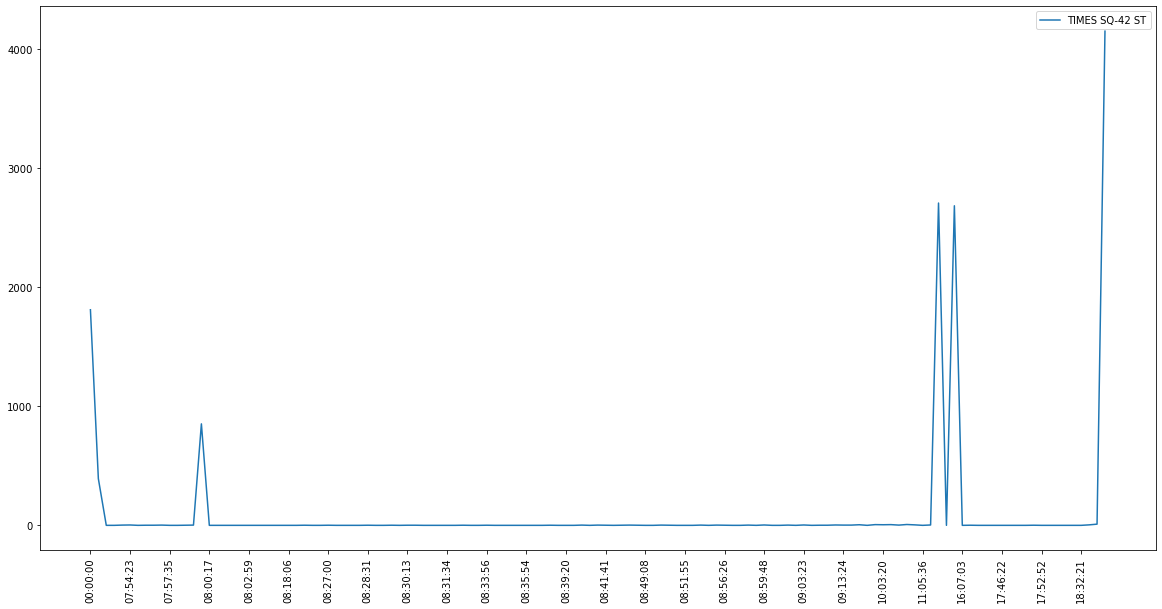

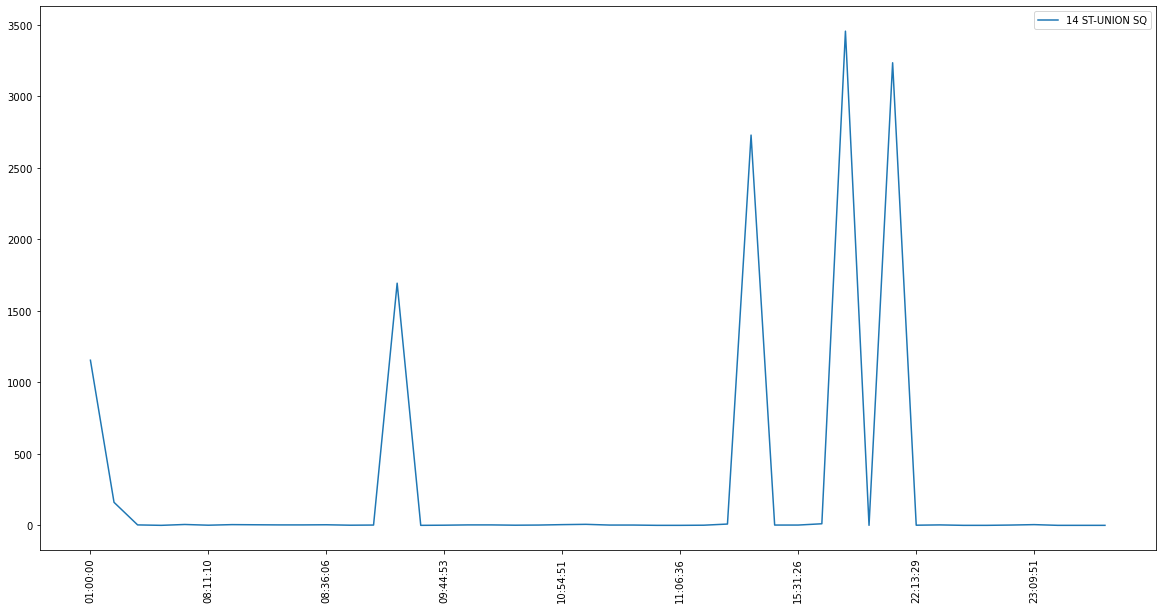

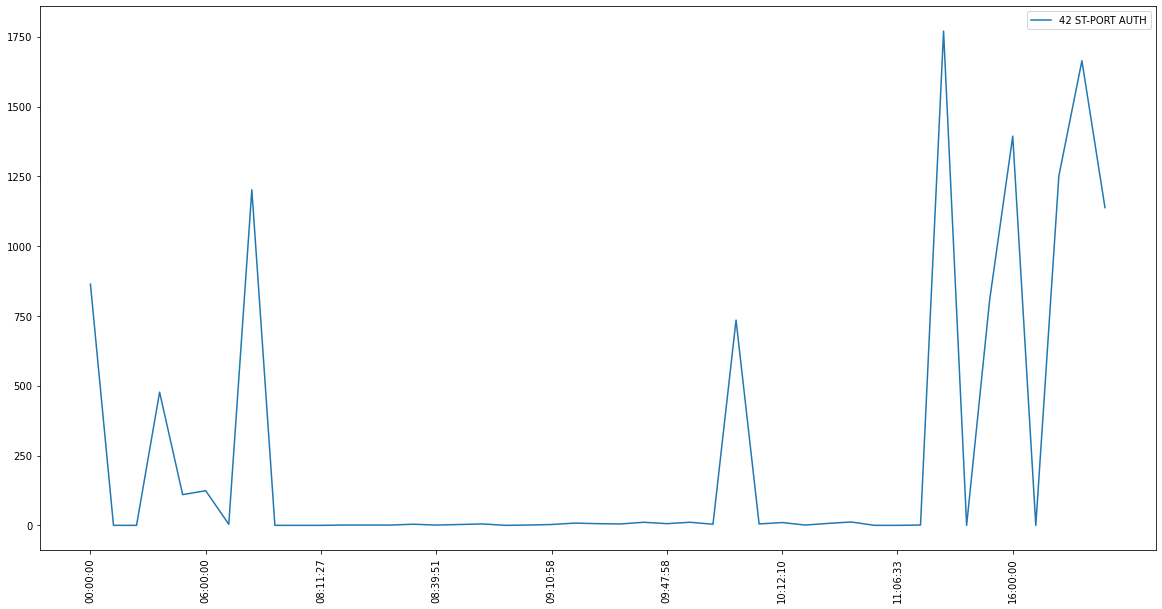

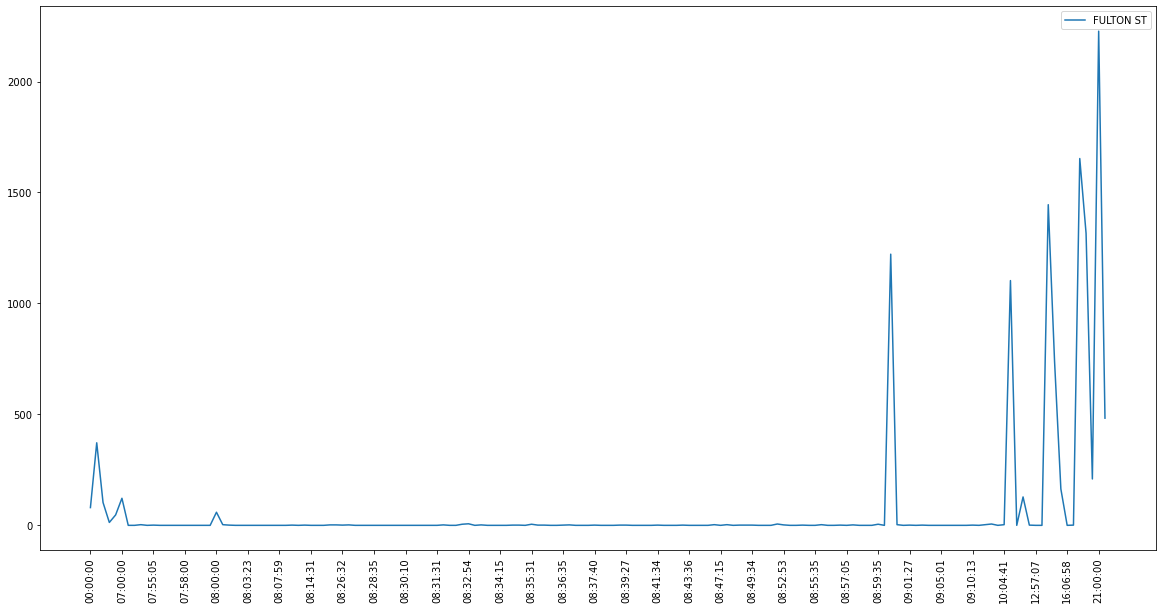

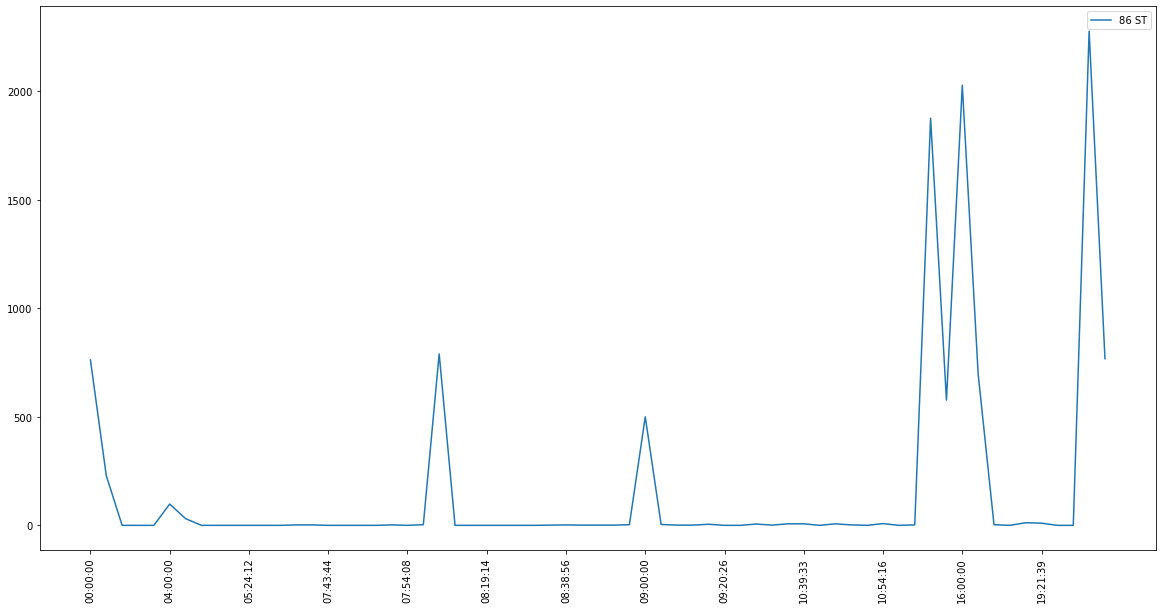

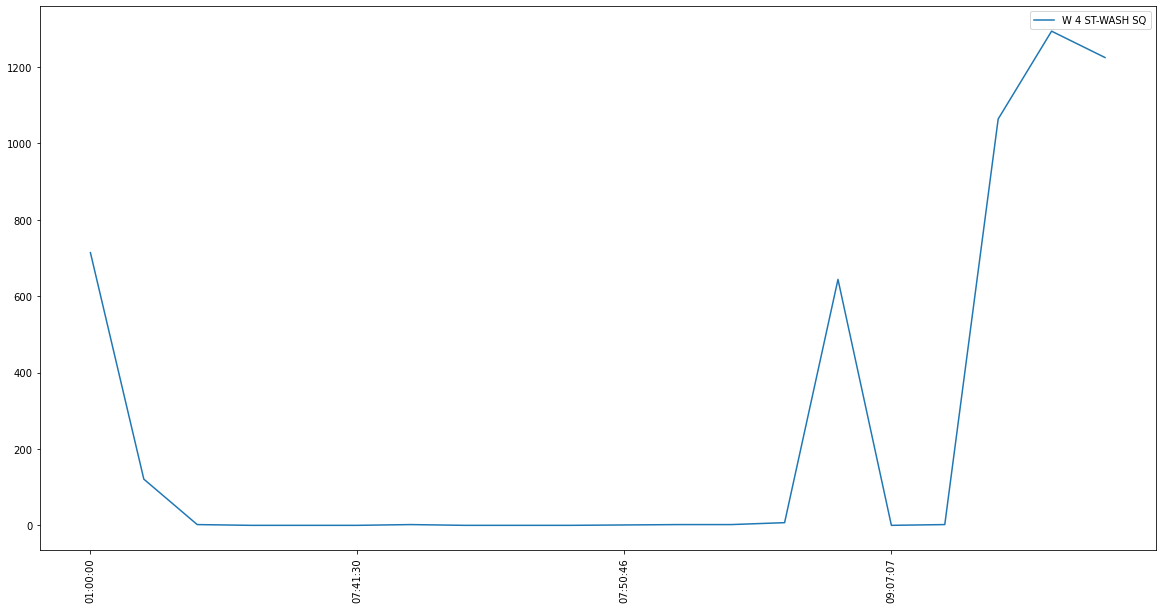

In [46]:
for stations in Top10:
     station = Top10_station_hourly[Top10_station_hourly['STATION'] == stations]
     fig, ax = plt.subplots()
     ax.plot(station['TIME'],station['TOTAL_TRAFFIC']//1000,label = stations)
     ax.set_xticks(ax.get_xticks()[::5])
     plt.xticks(rotation = 'vertical')
     plt.legend()
plt.legend()
plt.show()

### These plots show how traffic throughout the days varies between stations

### But WTC always busy

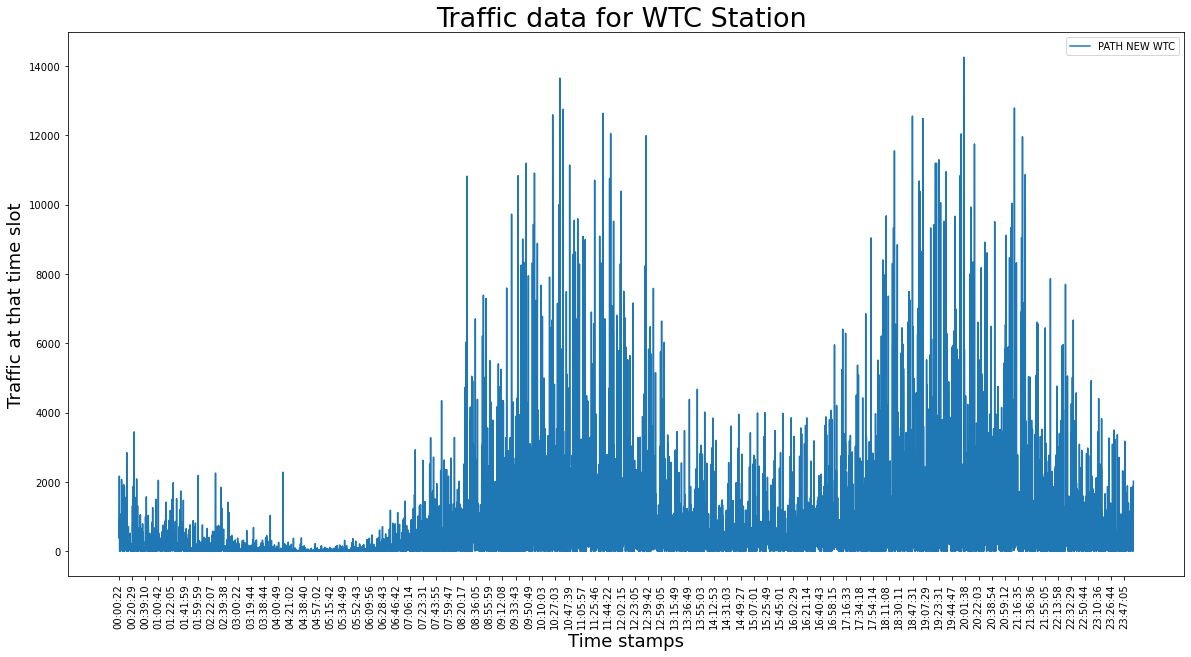

In [47]:
wtc_station = grouped_time[grouped_time['STATION'] == "PATH NEW WTC"]
wtc_station_hourly = wtc_station.groupby(['STATION','TIME']).TOTAL_TRAFFIC.sum().reset_index()
fig, ax = plt.subplots()
ax.plot(wtc_station_hourly['TIME'],wtc_station_hourly['TOTAL_TRAFFIC'],label = "PATH NEW WTC")
ax.set_xticks(ax.get_xticks()[::100])
plt.xticks(rotation = 'vertical')
plt.xlabel("Time stamps", fontsize=18)
plt.ylabel("Traffic at that time slot",fontsize=18)
plt.title("Traffic data for WTC Station ",fontsize=27)
plt.rcParams.update({'font.size': 10})
plt.savefig('WTC_traffic.png', dpi=300)
plt.legend()
plt.show()

## Finding time of day for high traffic

In [48]:
grouped_time['FIRST'] =  grouped_time.TIME.astype(str).str[:2].astype(int) #grabbing first two numbers of timestamp

In [49]:
def make_time_bins(row):
    """
    make_time_bins allows us to group turnstile data entries in buckets to make
    recommedations on "shifts" for the street teams should be at the busiest stations
    """
    if (row['FIRST'] >=0 and row['FIRST'] <= 4):
        return "Night"
    elif (row['FIRST'] >4 and row['FIRST'] <= 8):
        return "Early Morning"
    elif (row['FIRST'] >8 and row['FIRST'] < 12):
        return "Morning"
    elif (row['FIRST'] >=12 and row['FIRST'] < 17):
        return "Afternoon"
    elif (row['FIRST'] >=17 and row['FIRST'] < 21):
        return "Evening"
    else: return "Night"
    return 

In [50]:
grouped_time["TIME_BINS"] = grouped_time.apply(make_time_bins, axis=1)
grouped_time.head()

STATION DIVISION       DATE      TIME           Date_Time  \
1   59 ST      BMT 2019-05-11  04:00:00 2019-05-11 04:00:00   
2   59 ST      BMT 2019-05-11  08:00:00 2019-05-11 08:00:00   
3   59 ST      BMT 2019-05-11  12:00:00 2019-05-11 12:00:00   
4   59 ST      BMT 2019-05-11  16:00:00 2019-05-11 16:00:00   
5   59 ST      BMT 2019-05-11  20:00:00 2019-05-11 20:00:00   

               Turnstile  Week_Day  TOTAL_TRAFFIC  FIRST      TIME_BINS  
1  A002R05102-00-0059 ST  Saturday           31.0      4          Night  
2  A002R05102-00-0059 ST  Saturday           51.0      8  Early Morning  
3  A002R05102-00-0059 ST  Saturday          144.0     12      Afternoon  
4  A002R05102-00-0059 ST  Saturday          282.0     16      Afternoon  
5  A002R05102-00-0059 ST  Saturday          339.0     20        Evening

In [51]:
#Only grab stations in the Top 10 since that's what we care about
Top10_stations = grouped_time[grouped_time['STATION'].isin(Top10)]
Top10_station_slot = Top10_stations.groupby(['STATION','TIME_BINS']).TOTAL_TRAFFIC.sum().reset_index()

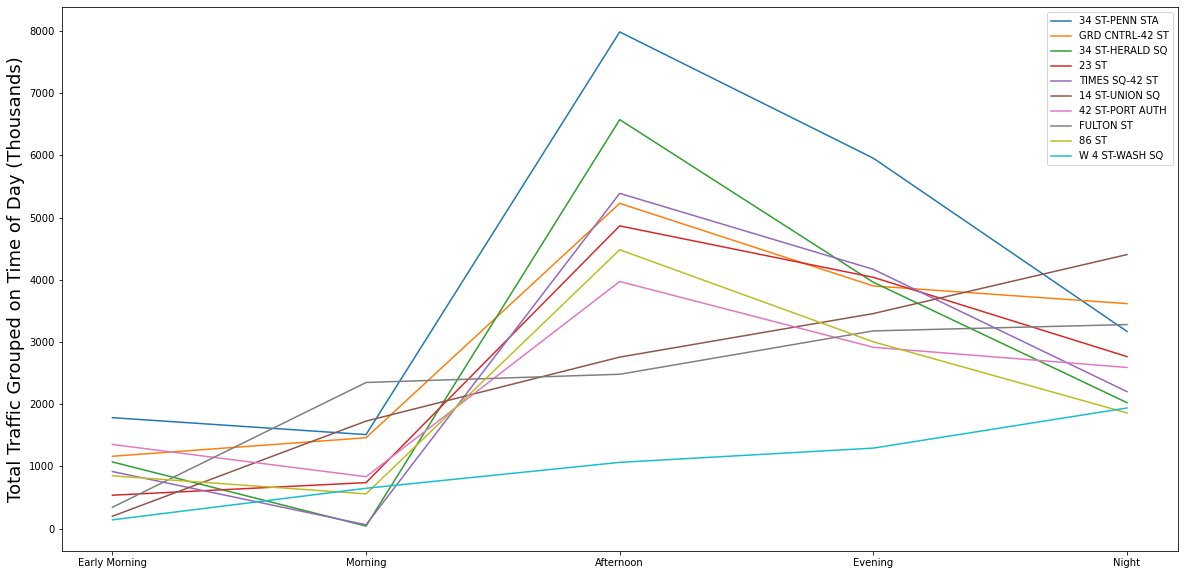

In [52]:
timeaxis_list = ["Early Morning", "Morning", "Afternoon", "Evening", "Night"]

for stations in Top10:
    station = Top10_station_slot[Top10_station_slot['STATION'] == stations]
    station = station.set_index('TIME_BINS').loc[timeaxis_list]
    plt.plot(station['TOTAL_TRAFFIC']/1000,label = stations)
    
plt.ylabel("Total Traffic Grouped on Time of Day (Thousands)",fontsize=18)
plt.rcParams.update({'font.size': 10})
plt.legend()
plt.savefig('Traffic_trend.png',dpi = 300)
plt.show()

In [53]:
#Declaring object to apply masks to in order to grab the top stations for each "time bin"
#top103sorted = Top 10 Stations in 3 Time Bins sorted
top103sorted = Top10_station_slot.sort_values("TOTAL_TRAFFIC", ascending=False)

In [54]:
#Morning Top 10
mask = top103sorted["TIME_BINS"] == "Morning"
top103sorted[mask].reset_index()

index          STATION TIME_BINS  TOTAL_TRAFFIC
0     33        FULTON ST   Morning      2349316.0
1      3   14 ST-UNION SQ   Morning      1728476.0
2     18   34 ST-PENN STA   Morning      1511593.0
3     38  GRD CNTRL-42 ST   Morning      1460753.0
4     23  42 ST-PORT AUTH   Morning       834698.0
5      8            23 ST   Morning       739392.0
6     48   W 4 ST-WASH SQ   Morning       648094.0
7     28            86 ST   Morning       557980.0
8     43   TIMES SQ-42 ST   Morning        61284.0
9     13  34 ST-HERALD SQ   Morning        40235.0

In [55]:
#Afternoon Top 10
mask = top103sorted["TIME_BINS"] == "Afternoon"
top103sorted[mask].reset_index()

index          STATION  TIME_BINS  TOTAL_TRAFFIC
0     15   34 ST-PENN STA  Afternoon      7986739.0
1     10  34 ST-HERALD SQ  Afternoon      6576176.0
2     40   TIMES SQ-42 ST  Afternoon      5390127.0
3     35  GRD CNTRL-42 ST  Afternoon      5229815.0
4      5            23 ST  Afternoon      4867651.0
5     25            86 ST  Afternoon      4483533.0
6     20  42 ST-PORT AUTH  Afternoon      3973678.0
7      0   14 ST-UNION SQ  Afternoon      2757431.0
8     30        FULTON ST  Afternoon      2481580.0
9     45   W 4 ST-WASH SQ  Afternoon      1064773.0

In [56]:
#Evening Top 10
mask = top103sorted["TIME_BINS"] == "Evening"
top103sorted[mask].reset_index()

index          STATION TIME_BINS  TOTAL_TRAFFIC
0     17   34 ST-PENN STA   Evening      5955633.0
1     42   TIMES SQ-42 ST   Evening      4169159.0
2      7            23 ST   Evening      4040193.0
3     12  34 ST-HERALD SQ   Evening      3960876.0
4     37  GRD CNTRL-42 ST   Evening      3901629.0
5      2   14 ST-UNION SQ   Evening      3457628.0
6     32        FULTON ST   Evening      3179060.0
7     27            86 ST   Evening      3003502.0
8     22  42 ST-PORT AUTH   Evening      2915321.0
9     47   W 4 ST-WASH SQ   Evening      1294322.0

In [57]:
def make_time_bins1(row):
    """
    make_time_bins1 is the same function as make_time_bins,
    but buckets our times into only 2 partitions - Pre-Noon & Post-Noon
    """
    if (row['FIRST'] >=4 and row['FIRST'] <= 12):
        return "Pre-Noon"
    elif (row['FIRST'] >12 and row['FIRST'] <= 20):
        return "Post-Noon"
    return 

In [58]:
grouped_time["TIME_BINS1"] = grouped_time.apply(make_time_bins1, axis=1)

grouped_time.head()

STATION DIVISION       DATE      TIME           Date_Time  \
1   59 ST      BMT 2019-05-11  04:00:00 2019-05-11 04:00:00   
2   59 ST      BMT 2019-05-11  08:00:00 2019-05-11 08:00:00   
3   59 ST      BMT 2019-05-11  12:00:00 2019-05-11 12:00:00   
4   59 ST      BMT 2019-05-11  16:00:00 2019-05-11 16:00:00   
5   59 ST      BMT 2019-05-11  20:00:00 2019-05-11 20:00:00   

               Turnstile  Week_Day  TOTAL_TRAFFIC  FIRST      TIME_BINS  \
1  A002R05102-00-0059 ST  Saturday           31.0      4          Night   
2  A002R05102-00-0059 ST  Saturday           51.0      8  Early Morning   
3  A002R05102-00-0059 ST  Saturday          144.0     12      Afternoon   
4  A002R05102-00-0059 ST  Saturday          282.0     16      Afternoon   
5  A002R05102-00-0059 ST  Saturday          339.0     20        Evening   

  TIME_BINS1  
1   Pre-Noon  
2   Pre-Noon  
3   Pre-Noon  
4  Post-Noon  
5  Post-Noon

In [59]:
#Only grab stations in the Top 10 since that's what we care about
Top10_stations = grouped_time[grouped_time['STATION'].isin(Top10)]
Top10_station_slot1 = Top10_stations.groupby(['STATION','TIME_BINS1']).TOTAL_TRAFFIC.sum().reset_index()

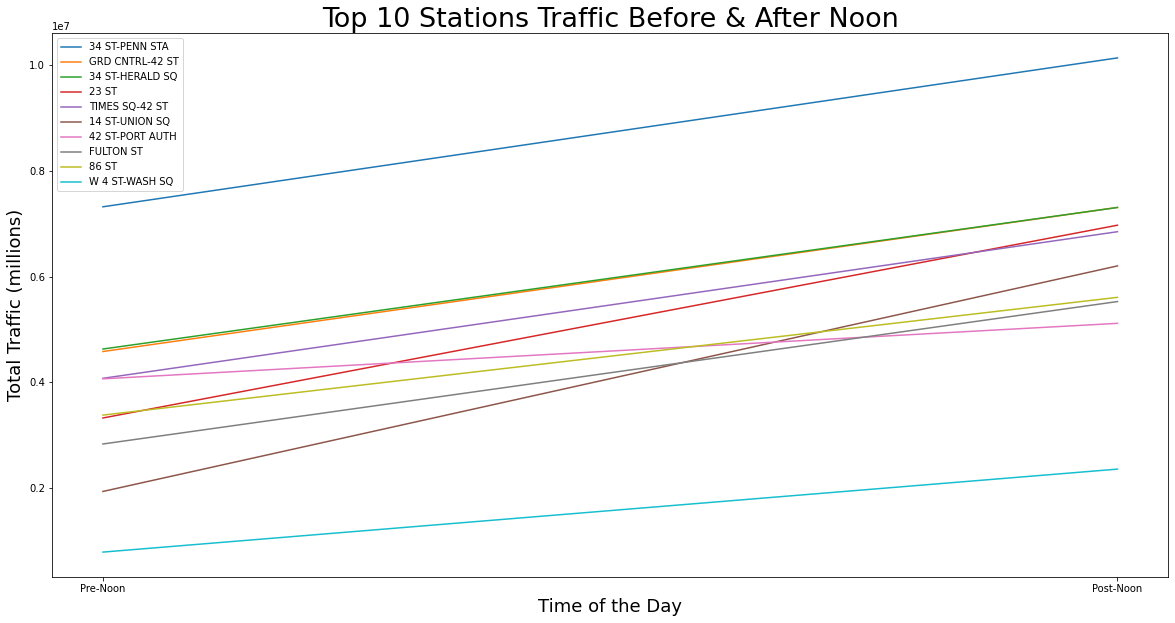

In [60]:
timeaxis_list = ["Pre-Noon","Post-Noon"]

for stations in Top10:
    station = Top10_station_slot1[Top10_station_slot1['STATION'] == stations]
    station = station.set_index('TIME_BINS1').loc[timeaxis_list]
    plt.plot(station['TOTAL_TRAFFIC'],label = stations)
    
plt.xlabel("Time of the Day", fontsize=18)
plt.ylabel("Total Traffic (millions)",fontsize=18)
plt.title("Top 10 Stations Traffic Before & After Noon",fontsize=27)
plt.rcParams.update({'font.size': 10})
plt.legend()
plt.show()

In [61]:
#Declaring object to apply masks to in order to grab the top stations for each "time bin"
#top102sorted = Top 10 Stations in 2 Time Bins sorted
top102sorted = Top10_station_slot1.sort_values("TOTAL_TRAFFIC", ascending=False)

In [62]:
#Morning Top 10 (Pre-Noon)
mask = top102sorted["TIME_BINS1"] == "Pre-Noon"
top102sorted[mask].reset_index()

index          STATION TIME_BINS1  TOTAL_TRAFFIC
0      7   34 ST-PENN STA   Pre-Noon      7324336.0
1      5  34 ST-HERALD SQ   Pre-Noon      4632358.0
2     15  GRD CNTRL-42 ST   Pre-Noon      4584929.0
3     17   TIMES SQ-42 ST   Pre-Noon      4077760.0
4      9  42 ST-PORT AUTH   Pre-Noon      4068120.0
5     11            86 ST   Pre-Noon      3381816.0
6      3            23 ST   Pre-Noon      3326976.0
7     13        FULTON ST   Pre-Noon      2834985.0
8      1   14 ST-UNION SQ   Pre-Noon      1936612.0
9     19   W 4 ST-WASH SQ   Pre-Noon       788882.0

In [63]:
#Afternoon/Evening Top 10 (Post-Noon)
mask1 = top102sorted["TIME_BINS1"] == "Post-Noon"
top102sorted[mask1].reset_index()

index          STATION TIME_BINS1  TOTAL_TRAFFIC
0      6   34 ST-PENN STA  Post-Noon     10141955.0
1     14  GRD CNTRL-42 ST  Post-Noon      7312015.0
2      4  34 ST-HERALD SQ  Post-Noon      7311144.0
3      2            23 ST  Post-Noon      6975514.0
4     16   TIMES SQ-42 ST  Post-Noon      6852557.0
5      0   14 ST-UNION SQ  Post-Noon      6205343.0
6     10            86 ST  Post-Noon      5610160.0
7     12        FULTON ST  Post-Noon      5530669.0
8      8  42 ST-PORT AUTH  Post-Noon      5118231.0
9     18   W 4 ST-WASH SQ  Post-Noon      2359095.0

## Find High Traffic Areas For Games

In [64]:
pwd

'/Users/jseemayer/Documents/Me/Metis/mta-project-1'

Changing directory to load in schedule data files:

In [65]:
cd Schedule Data

/Users/jseemayer/Documents/Me/Metis/mta-project-1/Schedule Data


### Reading in the 2019 MLB Schedule CSV data

In [66]:
schedule_2019 = pd.read_csv("2019SKED.TXT")

In [67]:
#scope out the data
schedule_2019.head()

20190320  0  Wed  SEA  AL  1  OAK AL.1  1.1  n Unnamed: 10 Unnamed: 11
0  20190321  0  Thu  SEA  AL  2  OAK   AL    2  n         NaN         NaN
1  20190328  0  Thu  ANA  AL  1  OAK   AL    3  d         NaN         NaN
2  20190328  0  Thu  ARI  NL  1  LAN   NL    1  d         NaN         NaN
3  20190328  0  Thu  ATL  NL  1  PHI   NL    1  d         NaN         NaN
4  20190328  0  Thu  BAL  AL  1  NYA   AL    1  d         NaN         NaN

Columns are the first row, need to rename based on the site definitions:

In [68]:
schedule_2019.columns=['Date','GameNumber','WeekDay','VisitingTeam','VisitingTeamLeague','VisitingTeamGame','HomeTeam','HomeTeamLeague','HomeTeamGame','GameTime','CancelIndicator','MakeUpDate']
schedule_2019.head()

Date  GameNumber WeekDay VisitingTeam VisitingTeamLeague  \
0  20190321           0     Thu          SEA                 AL   
1  20190328           0     Thu          ANA                 AL   
2  20190328           0     Thu          ARI                 NL   
3  20190328           0     Thu          ATL                 NL   
4  20190328           0     Thu          BAL                 AL   

   VisitingTeamGame HomeTeam HomeTeamLeague  HomeTeamGame GameTime  \
0                 2      OAK             AL             2        n   
1                 1      OAK             AL             3        d   
2                 1      LAN             NL             1        d   
3                 1      PHI             NL             1        d   
4                 1      NYA             AL             1        d   

  CancelIndicator MakeUpDate  
0             NaN        NaN  
1             NaN        NaN  
2             NaN        NaN  
3             NaN        NaN  
4             NaN        NaN

In [69]:
#adding a DateTime element to the schedule data to match with the subway data
schedule_2019['DateTime'] = pd.to_datetime(schedule_2019.Date, format='%Y%m%d')

Pulling the team abbreviations, each should have about 81 home games, depending on cancellations:

In [70]:
schedule_2019.groupby(['HomeTeam']).GameNumber.count()

HomeTeam
ANA    81
ARI    81
ATL    81
BAL    81
BOS    81
CHA    81
CHN    81
CIN    81
CLE    81
COL    81
DET    81
HOU    81
KCA    81
LAN    81
MIA    81
MIL    81
MIN    81
NYA    81
NYN    81
OAK    80
PHI    81
PIT    81
SDN    81
SEA    81
SFN    81
SLN    81
TBA    81
TEX    81
TOR    81
WAS    81
Name: GameNumber, dtype: int64

Finding New York Home games, with home teams NYA (Yankees) and NYN (Mets)

In [71]:
#Creating a mask
ny_home_games = ((schedule_2019.HomeTeam == 'NYA') |(schedule_2019.HomeTeam == 'NYN'))

In [72]:
ny_games_2019 = schedule_2019[ny_home_games]
ny_games_2019.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 162 entries, 4 to 2414
Data columns (total 13 columns):
 #   Column              Non-Null Count  Dtype         
---  ------              --------------  -----         
 0   Date                162 non-null    int64         
 1   GameNumber          162 non-null    int64         
 2   WeekDay             162 non-null    object        
 3   VisitingTeam        162 non-null    object        
 4   VisitingTeamLeague  162 non-null    object        
 5   VisitingTeamGame    162 non-null    int64         
 6   HomeTeam            162 non-null    object        
 7   HomeTeamLeague      162 non-null    object        
 8   HomeTeamGame        162 non-null    int64         
 9   GameTime            162 non-null    object        
 10  CancelIndicator     6 non-null      object        
 11  MakeUpDate          6 non-null      object        
 12  DateTime            162 non-null    datetime64[ns]
dtypes: datetime64[ns](1), int64(4), object(8)
memory 

Adding Date Time to ny_games dataframe:

In [73]:
ny_games_2019['DateTime'] = pd.to_datetime(ny_games_2019['Date'], format='%Y%m%d')

<ipython-input-73-05c8f9fc2885>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ny_games_2019['DateTime'] = pd.to_datetime(ny_games_2019['Date'], format='%Y%m%d')


In [74]:
ny_games_2019

Date  GameNumber WeekDay VisitingTeam VisitingTeamLeague  \
4     20190328           0     Thu          BAL                 AL   
27    20190330           0     Sat          BAL                 AL   
42    20190331           0     Sun          BAL                 AL   
61    20190401           0     Mon          DET                 AL   
72    20190402           0     Tue          DET                 AL   
...        ...         ...     ...          ...                ...   
2366  20190925           0     Wed          MIA                 NL   
2379  20190926           0     Thu          MIA                 NL   
2384  20190927           0     Fri          ATL                 NL   
2399  20190928           0     Sat          ATL                 NL   
2414  20190929           0     Sun          ATL                 NL   

      VisitingTeamGame HomeTeam HomeTeamLeague  HomeTeamGame GameTime  \
4                    1      NYA             AL             1        d   
27                   2      NYA             AL             2        d   
42                   3      NYA             AL             3        d   
61                   5      NYA             AL             4        n   
72                   6      NYA             AL             5        n   
...                ...      ...            ...           ...      ...   
2366               158      NYN             NL           158        n   
2379               159      NYN             NL           159        n   
2384               160      NYN             NL           160        n   
2399               161      NYN             NL           161        n   
2414               162      NYN             NL           162        d   

     CancelIndicator MakeUpDate   DateTime  
4                NaN        NaN 2019-03-28  
27               NaN        NaN 2019-03-30  
42               NaN        NaN 2019-03-31  
61               NaN        NaN 2019-04-01  
72               NaN        NaN 2019-04-02  
...              ...        ...        ...  
2366             NaN        NaN 2019-09-25  
2379             NaN        NaN 2019-09-26  
2384             NaN        NaN 2019-09-27  
2399             NaN        NaN 2019-09-28  
2414             NaN        NaN 2019-09-29  

[162 rows x 13 columns]

In [75]:
#Dropping columns that are not needed for merging the files
ny_games_2019.drop(columns = ['Date', 'GameNumber','VisitingTeam','VisitingTeamLeague','VisitingTeamGame', 'CancelIndicator','MakeUpDate'], inplace=True)

/Users/jseemayer/opt/anaconda3/lib/python3.8/site-packages/pandas/core/frame.py:4305: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().drop(


In [76]:
ny_games_2019.head()

WeekDay HomeTeam HomeTeamLeague  HomeTeamGame GameTime   DateTime
4      Thu      NYA             AL             1        d 2019-03-28
27     Sat      NYA             AL             2        d 2019-03-30
42     Sun      NYA             AL             3        d 2019-03-31
61     Mon      NYA             AL             4        n 2019-04-01
72     Tue      NYA             AL             5        n 2019-04-02

Yankee Games only:

In [77]:
yankee_games = ny_games_2019[ny_games_2019.HomeTeam == 'NYA']
yankee_games.value_counts(yankee_games.HomeTeam)

HomeTeam
NYA    81
dtype: int64

Mets Games only:

In [78]:
mets_games = ny_games_2019[ny_games_2019.HomeTeam == 'NYN']
mets_games.value_counts(mets_games.HomeTeam)

HomeTeam
NYN    81
dtype: int64

Creating a dataframe of just the Mets/Yankee stops:

In [79]:
#Reacquainting myself with the MTA data, grouped_time
grouped_time.sample(3)

STATION DIVISION       DATE      TIME           Date_Time  \
32076   GRAHAM AV      BMT 2019-06-14  12:00:00 2019-06-14 12:00:00   
134729      14 ST      IRT 2019-05-01  12:00:00 2019-05-01 12:00:00   
68066      104 ST      IND 2019-06-12  20:00:00 2019-06-12 20:00:00   

                        Turnstile   Week_Day  TOTAL_TRAFFIC  FIRST  TIME_BINS  \
32076   H014R24900-00-00GRAHAM AV     Friday          292.0     12  Afternoon   
134729      R127R10500-03-0014 ST  Wednesday          227.0     12  Afternoon   
68066      N137R35400-00-02104 ST  Wednesday           62.0     20    Evening   

       TIME_BINS1  
32076    Pre-Noon  
134729   Pre-Noon  
68066   Post-Noon

In [80]:
stadium_stations = grouped_time[(grouped_time.STATION == '161/YANKEE STAD') | (grouped_time.STATION == 'METS-WILLETS PT')]
stadium_stations.head()

STATION DIVISION       DATE      TIME           Date_Time  \
72748  161/YANKEE STAD      IND 2019-05-11  04:22:00 2019-05-11 04:22:00   
72749  161/YANKEE STAD      IND 2019-05-11  08:22:00 2019-05-11 08:22:00   
72750  161/YANKEE STAD      IND 2019-05-11  12:22:00 2019-05-11 12:22:00   
72751  161/YANKEE STAD      IND 2019-05-11  16:22:00 2019-05-11 16:22:00   
72752  161/YANKEE STAD      IND 2019-05-11  20:22:00 2019-05-11 20:22:00   

                             Turnstile  Week_Day  TOTAL_TRAFFIC  FIRST  \
72748  N203R19500-00-00161/YANKEE STAD  Saturday           12.0      4   
72749  N203R19500-00-00161/YANKEE STAD  Saturday           72.0      8   
72750  N203R19500-00-00161/YANKEE STAD  Saturday          176.0     12   
72751  N203R19500-00-00161/YANKEE STAD  Saturday          279.0     16   
72752  N203R19500-00-00161/YANKEE STAD  Saturday          195.0     20   

           TIME_BINS TIME_BINS1  
72748          Night   Pre-Noon  
72749  Early Morning   Pre-Noon  
72750      Afternoon   Pre-Noon  
72751      Afternoon  Post-Noon  
72752        Evening  Post-Noon

Creating a DateTime object to help join to the subway data.

In [81]:
stadium_stations['DateTime'] = pd.to_datetime(stadium_stations['DATE'], cache=True)

<ipython-input-81-b146b246bf79>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  stadium_stations['DateTime'] = pd.to_datetime(stadium_stations['DATE'], cache=True)


Adding Yankee Games to the stadium_stations dataframe:

In [82]:
stadium_with_yankeegames = stadium_stations.merge(yankee_games, how='left', on='DateTime')
stadium_with_yankeegames.head()

STATION DIVISION       DATE      TIME           Date_Time  \
0  161/YANKEE STAD      IND 2019-05-11  04:22:00 2019-05-11 04:22:00   
1  161/YANKEE STAD      IND 2019-05-11  08:22:00 2019-05-11 08:22:00   
2  161/YANKEE STAD      IND 2019-05-11  12:22:00 2019-05-11 12:22:00   
3  161/YANKEE STAD      IND 2019-05-11  16:22:00 2019-05-11 16:22:00   
4  161/YANKEE STAD      IND 2019-05-11  20:22:00 2019-05-11 20:22:00   

                         Turnstile  Week_Day  TOTAL_TRAFFIC  FIRST  \
0  N203R19500-00-00161/YANKEE STAD  Saturday           12.0      4   
1  N203R19500-00-00161/YANKEE STAD  Saturday           72.0      8   
2  N203R19500-00-00161/YANKEE STAD  Saturday          176.0     12   
3  N203R19500-00-00161/YANKEE STAD  Saturday          279.0     16   
4  N203R19500-00-00161/YANKEE STAD  Saturday          195.0     20   

       TIME_BINS TIME_BINS1   DateTime WeekDay HomeTeam HomeTeamLeague  \
0          Night   Pre-Noon 2019-05-11     NaN      NaN            NaN   
1  Early Morning   Pre-Noon 2019-05-11     NaN      NaN            NaN   
2      Afternoon   Pre-Noon 2019-05-11     NaN      NaN            NaN   
3      Afternoon  Post-Noon 2019-05-11     NaN      NaN            NaN   
4        Evening  Post-Noon 2019-05-11     NaN      NaN            NaN   

   HomeTeamGame GameTime  
0           NaN      NaN  
1           NaN      NaN  
2           NaN      NaN  
3           NaN      NaN  
4           NaN      NaN

In [83]:
#remove unneeded columns
stadium_with_yankeegames.drop(columns=['WeekDay','HomeTeamLeague','HomeTeamGame','GameTime'], inplace=True)
stadium_with_yankeegames.head()

STATION DIVISION       DATE      TIME           Date_Time  \
0  161/YANKEE STAD      IND 2019-05-11  04:22:00 2019-05-11 04:22:00   
1  161/YANKEE STAD      IND 2019-05-11  08:22:00 2019-05-11 08:22:00   
2  161/YANKEE STAD      IND 2019-05-11  12:22:00 2019-05-11 12:22:00   
3  161/YANKEE STAD      IND 2019-05-11  16:22:00 2019-05-11 16:22:00   
4  161/YANKEE STAD      IND 2019-05-11  20:22:00 2019-05-11 20:22:00   

                         Turnstile  Week_Day  TOTAL_TRAFFIC  FIRST  \
0  N203R19500-00-00161/YANKEE STAD  Saturday           12.0      4   
1  N203R19500-00-00161/YANKEE STAD  Saturday           72.0      8   
2  N203R19500-00-00161/YANKEE STAD  Saturday          176.0     12   
3  N203R19500-00-00161/YANKEE STAD  Saturday          279.0     16   
4  N203R19500-00-00161/YANKEE STAD  Saturday          195.0     20   

       TIME_BINS TIME_BINS1   DateTime HomeTeam  
0          Night   Pre-Noon 2019-05-11      NaN  
1  Early Morning   Pre-Noon 2019-05-11      NaN  
2      Afternoon   Pre-Noon 2019-05-11      NaN  
3      Afternoon  Post-Noon 2019-05-11      NaN  
4        Evening  Post-Noon 2019-05-11      NaN

In [84]:
#rename column to Yankee Games, otherwise loading in Mets data causes an error
stadium_with_yankeegames.rename(columns = {'HomeTeam':'YankeeGame'}, inplace=True)
stadium_with_yankeegames.head()

STATION DIVISION       DATE      TIME           Date_Time  \
0  161/YANKEE STAD      IND 2019-05-11  04:22:00 2019-05-11 04:22:00   
1  161/YANKEE STAD      IND 2019-05-11  08:22:00 2019-05-11 08:22:00   
2  161/YANKEE STAD      IND 2019-05-11  12:22:00 2019-05-11 12:22:00   
3  161/YANKEE STAD      IND 2019-05-11  16:22:00 2019-05-11 16:22:00   
4  161/YANKEE STAD      IND 2019-05-11  20:22:00 2019-05-11 20:22:00   

                         Turnstile  Week_Day  TOTAL_TRAFFIC  FIRST  \
0  N203R19500-00-00161/YANKEE STAD  Saturday           12.0      4   
1  N203R19500-00-00161/YANKEE STAD  Saturday           72.0      8   
2  N203R19500-00-00161/YANKEE STAD  Saturday          176.0     12   
3  N203R19500-00-00161/YANKEE STAD  Saturday          279.0     16   
4  N203R19500-00-00161/YANKEE STAD  Saturday          195.0     20   

       TIME_BINS TIME_BINS1   DateTime YankeeGame  
0          Night   Pre-Noon 2019-05-11        NaN  
1  Early Morning   Pre-Noon 2019-05-11        NaN  
2      Afternoon   Pre-Noon 2019-05-11        NaN  
3      Afternoon  Post-Noon 2019-05-11        NaN  
4        Evening  Post-Noon 2019-05-11        NaN

Adding Mets Games and combining:

In [85]:
stadium_with_combined_games = stadium_with_yankeegames.merge(mets_games, how='left', on='DateTime')
stadium_with_combined_games.head()

STATION DIVISION       DATE      TIME           Date_Time  \
0  161/YANKEE STAD      IND 2019-05-11  04:22:00 2019-05-11 04:22:00   
1  161/YANKEE STAD      IND 2019-05-11  08:22:00 2019-05-11 08:22:00   
2  161/YANKEE STAD      IND 2019-05-11  12:22:00 2019-05-11 12:22:00   
3  161/YANKEE STAD      IND 2019-05-11  16:22:00 2019-05-11 16:22:00   
4  161/YANKEE STAD      IND 2019-05-11  20:22:00 2019-05-11 20:22:00   

                         Turnstile  Week_Day  TOTAL_TRAFFIC  FIRST  \
0  N203R19500-00-00161/YANKEE STAD  Saturday           12.0      4   
1  N203R19500-00-00161/YANKEE STAD  Saturday           72.0      8   
2  N203R19500-00-00161/YANKEE STAD  Saturday          176.0     12   
3  N203R19500-00-00161/YANKEE STAD  Saturday          279.0     16   
4  N203R19500-00-00161/YANKEE STAD  Saturday          195.0     20   

       TIME_BINS TIME_BINS1   DateTime YankeeGame WeekDay HomeTeam  \
0          Night   Pre-Noon 2019-05-11        NaN     Sat      NYN   
1  Early Morning   Pre-Noon 2019-05-11        NaN     Sat      NYN   
2      Afternoon   Pre-Noon 2019-05-11        NaN     Sat      NYN   
3      Afternoon  Post-Noon 2019-05-11        NaN     Sat      NYN   
4        Evening  Post-Noon 2019-05-11        NaN     Sat      NYN   

  HomeTeamLeague  HomeTeamGame GameTime  
0             NL          39.0        n  
1             NL          39.0        n  
2             NL          39.0        n  
3             NL          39.0        n  
4             NL          39.0        n

In [86]:
stadium_with_combined_games.drop(columns=['WeekDay','HomeTeamLeague','HomeTeamGame','GameTime'], inplace=True)
stadium_with_combined_games.rename(columns = {'HomeTeam':'MetsGame'}, inplace=True)

Verifying the counts of Yankee Games and Mets Games are present:

In [87]:
stadium_with_combined_games.value_counts(stadium_with_combined_games.YankeeGame)

YankeeGame
NYA    15483
dtype: int64

In [88]:
stadium_with_combined_games.value_counts(stadium_with_combined_games.MetsGame)

MetsGame
NYN    14360
dtype: int64

Replacing na values with NoGame:

In [89]:
stadium_with_combined_games['YankeeGame'].fillna('NoGame', inplace=True)
stadium_with_combined_games['MetsGame'].fillna('NoGame', inplace=True)

In [90]:
#Combined Sheet with Mets/Yankee Games, pulling a sample to audit with mlb.com:
stadium_with_combined_games.sample(10)

STATION DIVISION       DATE      TIME           Date_Time  \
11182  METS-WILLETS PT      IRT 2019-06-03  21:00:00 2019-06-03 21:00:00   
11274  METS-WILLETS PT      IRT 2019-06-05  13:00:00 2019-06-05 13:00:00   
16204  161/YANKEE STAD      IRT 2019-05-27  00:22:00 2019-05-27 00:22:00   
20104  METS-WILLETS PT      IRT 2019-06-09  13:00:00 2019-06-09 13:00:00   
14670  METS-WILLETS PT      IRT 2019-04-22  09:00:00 2019-04-22 09:00:00   
16150  161/YANKEE STAD      IRT 2019-05-31  16:22:00 2019-05-31 16:22:00   
29513  METS-WILLETS PT      IRT 2019-05-08  09:00:00 2019-05-08 09:00:00   
24288  161/YANKEE STAD      IND 2019-04-12  08:22:00 2019-04-12 08:22:00   
2510   METS-WILLETS PT      IRT 2019-05-12  17:00:00 2019-05-12 17:00:00   
32223  METS-WILLETS PT      IRT 2019-04-30  01:00:00 2019-04-30 01:00:00   

                              Turnstile   Week_Day  TOTAL_TRAFFIC  FIRST  \
11182   R532R32800-06-01METS-WILLETS PT     Monday            0.0     21   
11274   R532R32800-06-03METS-WILLETS PT  Wednesday            0.0     13   
16204   R262R19503-06-01161/YANKEE STAD     Monday           38.0      0   
20104   R532R32800-05-04METS-WILLETS PT     Sunday           19.0     13   
14670  R532HR32802-00-05METS-WILLETS PT     Monday           79.0      9   
16150   R262R19503-03-02161/YANKEE STAD     Friday          479.0     16   
29513   R532R32800-06-05METS-WILLETS PT  Wednesday            0.0      9   
24288   N203R19500-00-01161/YANKEE STAD     Friday          471.0      8   
2510   R532HR32802-03-00METS-WILLETS PT     Sunday            1.0     17   
32223   R532R32800-05-04METS-WILLETS PT    Tuesday          151.0      1   

           TIME_BINS TIME_BINS1   DateTime YankeeGame MetsGame  
11182          Night       None 2019-06-03     NoGame   NoGame  
11274      Afternoon  Post-Noon 2019-06-05     NoGame      NYN  
16204          Night       None 2019-05-27        NYA   NoGame  
20104      Afternoon  Post-Noon 2019-06-09     NoGame      NYN  
14670        Morning   Pre-Noon 2019-04-22     NoGame      NYN  
16150      Afternoon  Post-Noon 2019-05-31        NYA   NoGame  
29513        Morning   Pre-Noon 2019-05-08        NYA   NoGame  
24288  Early Morning   Pre-Noon 2019-04-12        NYA   NoGame  
2510         Evening  Post-Noon 2019-05-12     NoGame      NYN  
32223          Night       None 2019-04-30     NoGame      NYN

All dates in sample set match with schedule correctly (did a quick audit)

Setting masks for games, no games to use for filtering:

In [91]:
yankee_game_mask = (stadium_with_combined_games.YankeeGame == 'NYA')
non_yankee_game_mask = (stadium_with_combined_games.YankeeGame == 'NoGame')
mets_game_mask = (stadium_with_combined_games.MetsGame == 'NYN')
non_mets_game_mask = (stadium_with_combined_games.MetsGame == 'NoGame')

Finding Yankees Game vs Non-Yankees Game at 161/Yankee Stadium Station:

In [92]:
#Yankee Stadium Stop w/ Yankee Games
yankee_game_df = stadium_with_combined_games[(stadium_with_combined_games.STATION == '161/YANKEE STAD') & yankee_game_mask]

In [93]:
#Yankee Stadium Stop w/o Yankee Games:
non_yankee_game_df = stadium_with_combined_games[(stadium_with_combined_games.STATION == '161/YANKEE STAD') & non_yankee_game_mask]

Finding Mets Game vs Non-Mets Game at METS-WILLETS PT Station:

In [94]:
#Mets Stadium Stop w/ Mets Games
mets_game_df = stadium_with_combined_games[(stadium_with_combined_games.STATION == 'METS-WILLETS PT') & mets_game_mask]

In [95]:
#Mets Stadium Stop w/o Mets Games
non_mets_game_df = stadium_with_combined_games[(stadium_with_combined_games.STATION == 'METS-WILLETS PT') & non_mets_game_mask]

In [96]:
mets_game_df.head()

STATION DIVISION       DATE      TIME           Date_Time  \
1517  METS-WILLETS PT      IRT 2019-05-11  05:00:00 2019-05-11 05:00:00   
1518  METS-WILLETS PT      IRT 2019-05-11  09:00:00 2019-05-11 09:00:00   
1519  METS-WILLETS PT      IRT 2019-05-11  13:00:00 2019-05-11 13:00:00   
1520  METS-WILLETS PT      IRT 2019-05-11  17:00:00 2019-05-11 17:00:00   
1521  METS-WILLETS PT      IRT 2019-05-11  21:00:00 2019-05-11 21:00:00   

                            Turnstile  Week_Day  TOTAL_TRAFFIC  FIRST  \
1517  R532R32800-00-00METS-WILLETS PT  Saturday           48.0      5   
1518  R532R32800-00-00METS-WILLETS PT  Saturday          110.0      9   
1519  R532R32800-00-00METS-WILLETS PT  Saturday          182.0     13   
1520  R532R32800-00-00METS-WILLETS PT  Saturday          454.0     17   
1521  R532R32800-00-00METS-WILLETS PT  Saturday            0.0     21   

          TIME_BINS TIME_BINS1   DateTime YankeeGame MetsGame  
1517  Early Morning   Pre-Noon 2019-05-11     NoGame      NYN  
1518        Morning   Pre-Noon 2019-05-11     NoGame      NYN  
1519      Afternoon  Post-Noon 2019-05-11     NoGame      NYN  
1520        Evening  Post-Noon 2019-05-11     NoGame      NYN  
1521          Night       None 2019-05-11     NoGame      NYN

In [97]:
yankee_game_df.head()

STATION DIVISION       DATE      TIME           Date_Time  \
11  161/YANKEE STAD      IND 2019-05-13  00:22:00 2019-05-13 00:22:00   
12  161/YANKEE STAD      IND 2019-05-13  04:22:00 2019-05-13 04:22:00   
13  161/YANKEE STAD      IND 2019-05-13  08:22:00 2019-05-13 08:22:00   
14  161/YANKEE STAD      IND 2019-05-13  12:22:00 2019-05-13 12:22:00   
15  161/YANKEE STAD      IND 2019-05-13  16:22:00 2019-05-13 16:22:00   

                          Turnstile Week_Day  TOTAL_TRAFFIC  FIRST  \
11  N203R19500-00-00161/YANKEE STAD   Monday           27.0      0   
12  N203R19500-00-00161/YANKEE STAD   Monday            4.0      4   
13  N203R19500-00-00161/YANKEE STAD   Monday          427.0      8   
14  N203R19500-00-00161/YANKEE STAD   Monday          516.0     12   
15  N203R19500-00-00161/YANKEE STAD   Monday          536.0     16   

        TIME_BINS TIME_BINS1   DateTime YankeeGame MetsGame  
11          Night       None 2019-05-13        NYA   NoGame  
12          Night   Pre-Noon 2019-05-13        NYA   NoGame  
13  Early Morning   Pre-Noon 2019-05-13        NYA   NoGame  
14      Afternoon   Pre-Noon 2019-05-13        NYA   NoGame  
15      Afternoon  Post-Noon 2019-05-13        NYA   NoGame

In [98]:
#Total Traffic on Yankee Game Days
yankee_game_traffic = yankee_game_df.groupby(['DateTime'], as_index=False).TOTAL_TRAFFIC.sum()
yankee_game_traffic.head()

DateTime  TOTAL_TRAFFIC
0 2019-03-30        44933.0
1 2019-03-31        31839.0
2 2019-04-01        41836.0
3 2019-04-02        50854.0
4 2019-04-03        61370.0

In [99]:
#Avg. Entries on Yankee Game Days at Yankee Stadium Stop:
yankee_gd_traffic = yankee_game_traffic.TOTAL_TRAFFIC.mean()
yankee_gd_traffic 

46964.305555555555

In [100]:
#Avg. Entries on Non-Yankee Game Days at Yankee Stadium Stop:
non_yankee_game_traffic = non_yankee_game_df.groupby(['DateTime'], as_index=False).TOTAL_TRAFFIC.sum()

In [101]:
#baseline value
yankee_ngd_traffic = non_yankee_game_traffic.TOTAL_TRAFFIC.mean()
yankee_ngd_traffic

34420.0

Mets Games

In [102]:
#Avg. Entries on Mets Game Days at Mets Stadium Stop:
mets_gd_df = mets_game_df.groupby(['DateTime'], as_index=False).TOTAL_TRAFFIC.sum()
mets_gd_df.head()

DateTime  TOTAL_TRAFFIC
0 2019-04-04        22473.0
1 2019-04-06        21899.0
2 2019-04-07        21290.0
3 2019-04-09        11547.0
4 2019-04-10        11059.0

In [103]:
#baseline traffic
mets_gd_traffic = mets_gd_df.TOTAL_TRAFFIC.mean()
mets_gd_traffic 

19014.272727272728

In [104]:
mets_ngd_df = non_mets_game_df.groupby(['DateTime'], as_index=False).TOTAL_TRAFFIC.sum()
mets_ngd_df.head()

DateTime  TOTAL_TRAFFIC
0 2019-03-30        56837.0
1 2019-03-31        46847.0
2 2019-04-01        12013.0
3 2019-04-02         5827.0
4 2019-04-03         6515.0

In [105]:
#Avg. Entries on Non-Mets Game Days at Mets Stadium Stop:
mets_ngd_traffic = mets_ngd_df.TOTAL_TRAFFIC.mean()
mets_ngd_traffic

16453.113636363636

Percent Difference: Yankee Games

In [106]:
#Finding "boosts" from gamedays
yankees_diff = yankee_gd_traffic - yankee_ngd_traffic
yankees_percent = ((yankee_gd_traffic - yankee_ngd_traffic) / (yankee_ngd_traffic))*100
print("Total difference between GameDay and Non-GameDay Traffic for New York Yankees: {}".format(yankees_diff))
print("Percent difference between GameDay and Non-GameDay Traffic for New York Yankees: {}%".format(yankees_percent))

Total difference between GameDay and Non-GameDay Traffic for New York Yankees: 12544.305555555555
Percent difference between GameDay and Non-GameDay Traffic for New York Yankees: 36.444815675640776%


Percent Difference: Mets Games

In [107]:
#Finding "boosts" from gamedays
mets_diff = mets_gd_traffic - mets_ngd_traffic
mets_percent = ((mets_gd_traffic - mets_ngd_traffic) / (mets_ngd_traffic))*100
print("Total difference between GameDay and Non-GameDay Traffic for New York Mets: {}".format(mets_diff))
print("Percent difference between GameDay and Non-GameDay Traffic for New York Mets: {}%".format(mets_percent))

Total difference between GameDay and Non-GameDay Traffic for New York Mets: 2561.159090909092
Percent difference between GameDay and Non-GameDay Traffic for New York Mets: 15.566409784276816%


Plotting GameDay Differences as a bar chart:

In [108]:
game_days = (yankee_gd_traffic, mets_gd_traffic)
non_game_days = (yankee_ngd_traffic, mets_ngd_traffic)

In [109]:
#Multi-plot set-up
N = 2
ind = np.arange(N)
width = 0.3

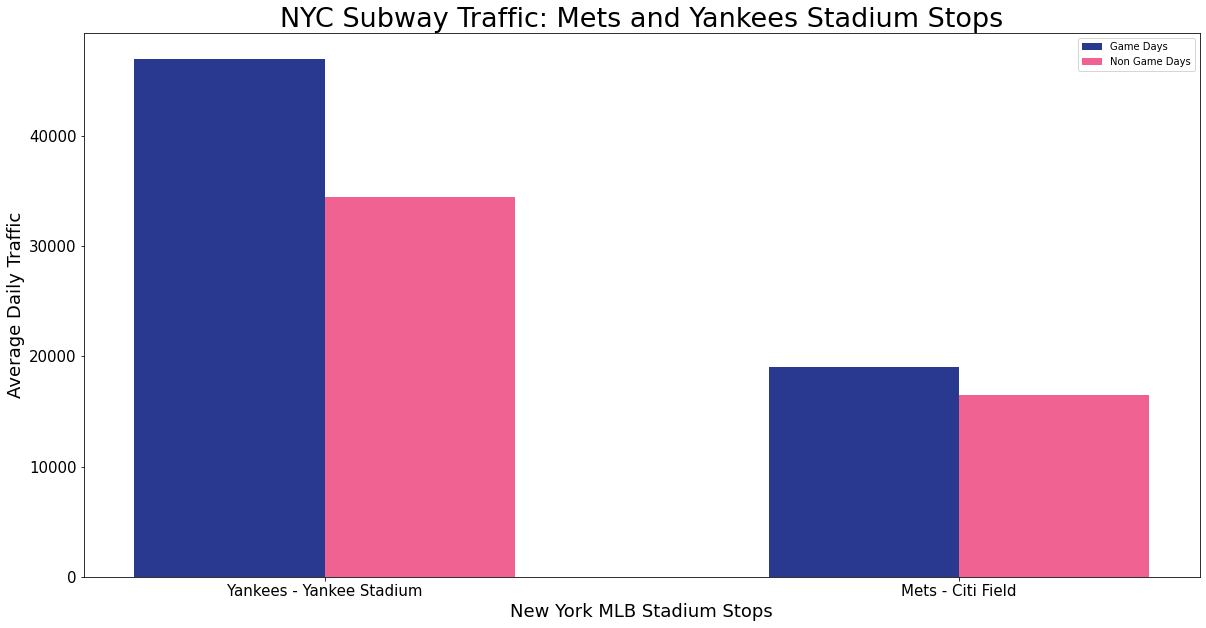

In [110]:
plt.bar(ind, game_days, width, label='Game Days', color = '#2a3990')
plt.bar(ind + width, non_game_days, width, label='Non Game Days', color = '#f06292')
plt.xlabel('New York MLB Stadium Stops', size = 18)
plt.ylabel('Average Daily Traffic', size = 18)
plt.title('NYC Subway Traffic: Mets and Yankees Stadium Stops', size=27)
plt.legend()
plt.xticks(ind + width / 2, ('Yankees - Yankee Stadium', 'Mets - Citi Field'), size=15)
plt.yticks(size=15)
plt.rcParams.update({'font.size': 11})
plt.savefig('nyc_mlb_traffic.jpg');

## NBA Schedule

Target: find gameday vs. non-gameday for knicks/nets

In [111]:
nba_schedule_2019 = pd.read_csv('nba-2018-UTC-08.csv')

In [112]:
nba_schedule_2019.head()

Round Number              Date                 Location  \
0             1  16/10/2018 16:00                TD Garden   
1             1  16/10/2018 18:30             ORACLE Arena   
2             1  17/10/2018 15:00          Spectrum Center   
3             1  17/10/2018 15:00     Little Caesars Arena   
4             1  17/10/2018 15:00  Bankers Life Fieldhouse   

               Home Team              Away Team  Result  
0         Boston Celtics     Philadelphia 76ers     NaN  
1  Golden State Warriors  Oklahoma City Thunder     NaN  
2      Charlotte Hornets        Milwaukee Bucks     NaN  
3        Detroit Pistons          Brooklyn Nets     NaN  
4         Indiana Pacers      Memphis Grizzlies     NaN

In [113]:
knicks_home_games = nba_schedule_2019[nba_schedule_2019['Home Team'] == 'New York Knicks']
knicks_home_games['Date_Time'] = pd.to_datetime(knicks_home_games['Date'], dayfirst=True)
knicks_home_games['DateTime'] = knicks_home_games['Date_Time'].dt.date
knicks_home_games['DateTime'] = pd.to_datetime(knicks_home_games['DateTime'])
knicks_home_games.sort_values(['Date_Time']).tail(15)

<ipython-input-113-e409209f8ce1>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  knicks_home_games['Date_Time'] = pd.to_datetime(knicks_home_games['Date'], dayfirst=True)
<ipython-input-113-e409209f8ce1>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  knicks_home_games['DateTime'] = knicks_home_games['Date_Time'].dt.date
<ipython-input-113-e409209f8ce1>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

Se

Round Number              Date               Location        Home Team  \
855             17  13/02/2019 16:30  Madison Square Garden  New York Knicks   
877             18  22/02/2019 16:30  Madison Square Garden  New York Knicks   
895             18  24/02/2019 16:30  Madison Square Garden  New York Knicks   
907             18  26/02/2019 16:30  Madison Square Garden  New York Knicks   
923             19  28/02/2019 16:30  Madison Square Garden  New York Knicks   
985             20  09/03/2019 09:00  Madison Square Garden  New York Knicks   
1041            21  17/03/2019 08:00  Madison Square Garden  New York Knicks   
1067            21  20/03/2019 15:30  Madison Square Garden  New York Knicks   
1081            22  22/03/2019 15:30  Madison Square Garden  New York Knicks   
1094            22  24/03/2019 08:00  Madison Square Garden  New York Knicks   
1124            22  28/03/2019 15:30  Madison Square Garden  New York Knicks   
1140            23  30/03/2019 15:30  Madison Square Garden  New York Knicks   
1154            23  01/04/2019 15:30  Madison Square Garden  New York Knicks   
1203            24  07/04/2019 15:30  Madison Square Garden  New York Knicks   
1222            24  10/04/2019 16:00  Madison Square Garden  New York Knicks   

                   Away Team  Result           Date_Time   DateTime  
855       Philadelphia 76ers     NaN 2019-02-13 16:30:00 2019-02-13  
877   Minnesota Timberwolves     NaN 2019-02-22 16:30:00 2019-02-22  
895        San Antonio Spurs     NaN 2019-02-24 16:30:00 2019-02-24  
907            Orlando Magic     NaN 2019-02-26 16:30:00 2019-02-26  
923      Cleveland Cavaliers     NaN 2019-02-28 16:30:00 2019-02-28  
985         Sacramento Kings     NaN 2019-03-09 09:00:00 2019-03-09  
1041      Los Angeles Lakers     NaN 2019-03-17 08:00:00 2019-03-17  
1067               Utah Jazz     NaN 2019-03-20 15:30:00 2019-03-20  
1081          Denver Nuggets     NaN 2019-03-22 15:30:00 2019-03-22  
1094             LA Clippers     NaN 2019-03-24 08:00:00 2019-03-24  
1124         Toronto Raptors     NaN 2019-03-28 15:30:00 2019-03-28  
1140              Miami Heat     NaN 2019-03-30 15:30:00 2019-03-30  
1154           Chicago Bulls     NaN 2019-04-01 15:30:00 2019-04-01  
1203      Washington Wizards     NaN 2019-04-07 15:30:00 2019-04-07  
1222         Detroit Pistons     NaN 2019-04-10 16:00:00 2019-04-10

In [114]:
nets_home_games = nba_schedule_2019[nba_schedule_2019['Home Team'] == 'Brooklyn Nets']
nets_home_games['Date_Time'] = pd.to_datetime(nets_home_games['Date'], dayfirst=True)
nets_home_games['DateTime'] = nets_home_games['Date_Time'].dt.date
nets_home_games['DateTime'] = pd.to_datetime(nets_home_games['DateTime'])
nets_home_games.tail(15)

<ipython-input-114-f15d5bcb479e>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  nets_home_games['Date_Time'] = pd.to_datetime(nets_home_games['Date'], dayfirst=True)
<ipython-input-114-f15d5bcb479e>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  nets_home_games['DateTime'] = nets_home_games['Date_Time'].dt.date
<ipython-input-114-f15d5bcb479e>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the ca

Round Number              Date         Location      Home Team  \
751             15  29/01/2019 16:30  Barclays Center  Brooklyn Nets   
791             16  04/02/2019 16:30  Barclays Center  Brooklyn Nets   
803             16  06/02/2019 16:30  Barclays Center  Brooklyn Nets   
819             17  08/02/2019 16:30  Barclays Center  Brooklyn Nets   
868             18  21/02/2019 16:30  Barclays Center  Brooklyn Nets   
899             18  25/02/2019 16:30  Barclays Center  Brooklyn Nets   
913             18  27/02/2019 16:30  Barclays Center  Brooklyn Nets   
928             19  01/03/2019 16:30  Barclays Center  Brooklyn Nets   
951             19  04/03/2019 16:30  Barclays Center  Brooklyn Nets   
968             19  06/03/2019 16:30  Barclays Center  Brooklyn Nets   
1002            20  11/03/2019 15:30  Barclays Center  Brooklyn Nets   
1136            23  30/03/2019 14:00  Barclays Center  Brooklyn Nets   
1153            23  01/04/2019 15:30  Barclays Center  Brooklyn Nets   
1168            23  03/04/2019 15:30  Barclays Center  Brooklyn Nets   
1220            24  10/04/2019 16:00  Barclays Center  Brooklyn Nets   

                   Away Team  Result           Date_Time   DateTime  
751            Chicago Bulls     NaN 2019-01-29 16:30:00 2019-01-29  
791          Milwaukee Bucks     NaN 2019-02-04 16:30:00 2019-02-04  
803           Denver Nuggets     NaN 2019-02-06 16:30:00 2019-02-06  
819            Chicago Bulls     NaN 2019-02-08 16:30:00 2019-02-08  
868   Portland Trail Blazers     NaN 2019-02-21 16:30:00 2019-02-21  
899        San Antonio Spurs     NaN 2019-02-25 16:30:00 2019-02-25  
913       Washington Wizards     NaN 2019-02-27 16:30:00 2019-02-27  
928        Charlotte Hornets     NaN 2019-03-01 16:30:00 2019-03-01  
951         Dallas Mavericks     NaN 2019-03-04 16:30:00 2019-03-04  
968      Cleveland Cavaliers     NaN 2019-03-06 16:30:00 2019-03-06  
1002         Detroit Pistons     NaN 2019-03-11 15:30:00 2019-03-11  
1136          Boston Celtics     NaN 2019-03-30 14:00:00 2019-03-30  
1153         Milwaukee Bucks     NaN 2019-04-01 15:30:00 2019-04-01  
1168         Toronto Raptors     NaN 2019-04-03 15:30:00 2019-04-03  
1220              Miami Heat     NaN 2019-04-10 16:00:00 2019-04-10

In [115]:
#Finding main stations for Nets & Knicks
#Dropping columns that are not needed for merging the files
knicks_home_games.drop(columns = ['Date', 'Round Number','Away Team','Result', 'Date_Time'], inplace=True)
nets_home_games.drop(columns = ['Date', 'Round Number','Away Team','Result', 'Date_Time'], inplace=True)

/Users/jseemayer/opt/anaconda3/lib/python3.8/site-packages/pandas/core/frame.py:4305: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().drop(


Madison Square Garden Stops: 34TH ST-HERALD SQ, 34 ST-PENN STA  
Barclays Center Stops: ATL AV-BARCLAY, FULTON ST, LAFAYETTE AV

Making a mask for the Knicks and Nets Stadium Stops:

In [116]:
msg_mask = ((grouped_time.STATION == '34 ST-HERALD SQ') | (grouped_time.STATION == '34 ST-PENN STA'))
barclays_mask = ((grouped_time.STATION == 'ATL AV-BARCLAY') | (grouped_time.STATION == 'FULTON ST') | (grouped_time.STATION == 'LAFAYETTE AV'))

In [117]:
#Finding nearby stations to the stadiums (Nets)
grouped_time[barclays_mask].STATION.value_counts()

FULTON ST         44095
ATL AV-BARCLAY    21967
LAFAYETTE AV       4502
Name: STATION, dtype: int64

In [118]:
#Finding nearby stations to the stadiums (Knicks)
grouped_time[msg_mask].STATION.value_counts()

34 ST-PENN STA     45265
34 ST-HERALD SQ    23852
Name: STATION, dtype: int64

### Creating a dataframe for knicks games only:

In [119]:
knicks_df = grouped_time[msg_mask]
knicks_df.head()

STATION DIVISION       DATE      TIME           Date_Time  \
2951  34 ST-HERALD SQ      BMT 2019-05-11  04:00:00 2019-05-11 04:00:00   
2952  34 ST-HERALD SQ      BMT 2019-05-11  08:00:00 2019-05-11 08:00:00   
2953  34 ST-HERALD SQ      BMT 2019-05-11  12:00:00 2019-05-11 12:00:00   
2954  34 ST-HERALD SQ      BMT 2019-05-11  16:00:00 2019-05-11 16:00:00   
2955  34 ST-HERALD SQ      BMT 2019-05-11  20:00:00 2019-05-11 20:00:00   

                            Turnstile  Week_Day  TOTAL_TRAFFIC  FIRST  \
2951  A022R02201-00-0034 ST-HERALD SQ  Saturday          254.0      4   
2952  A022R02201-00-0034 ST-HERALD SQ  Saturday          158.0      8   
2953  A022R02201-00-0034 ST-HERALD SQ  Saturday          807.0     12   
2954  A022R02201-00-0034 ST-HERALD SQ  Saturday         1640.0     16   
2955  A022R02201-00-0034 ST-HERALD SQ  Saturday         1746.0     20   

          TIME_BINS TIME_BINS1  
2951          Night   Pre-Noon  
2952  Early Morning   Pre-Noon  
2953      Afternoon   Pre-Noon  
2954      Afternoon  Post-Noon  
2955        Evening  Post-Noon

Converting the date to datetime to match with the schedule data:

In [120]:
knicks_df['DateTime'] = pd.to_datetime(knicks_df['DATE'], cache=True)

<ipython-input-120-a92c4ca7619e>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  knicks_df['DateTime'] = pd.to_datetime(knicks_df['DATE'], cache=True)


In [121]:
knicks_df.head()

STATION DIVISION       DATE      TIME           Date_Time  \
2951  34 ST-HERALD SQ      BMT 2019-05-11  04:00:00 2019-05-11 04:00:00   
2952  34 ST-HERALD SQ      BMT 2019-05-11  08:00:00 2019-05-11 08:00:00   
2953  34 ST-HERALD SQ      BMT 2019-05-11  12:00:00 2019-05-11 12:00:00   
2954  34 ST-HERALD SQ      BMT 2019-05-11  16:00:00 2019-05-11 16:00:00   
2955  34 ST-HERALD SQ      BMT 2019-05-11  20:00:00 2019-05-11 20:00:00   

                            Turnstile  Week_Day  TOTAL_TRAFFIC  FIRST  \
2951  A022R02201-00-0034 ST-HERALD SQ  Saturday          254.0      4   
2952  A022R02201-00-0034 ST-HERALD SQ  Saturday          158.0      8   
2953  A022R02201-00-0034 ST-HERALD SQ  Saturday          807.0     12   
2954  A022R02201-00-0034 ST-HERALD SQ  Saturday         1640.0     16   
2955  A022R02201-00-0034 ST-HERALD SQ  Saturday         1746.0     20   

          TIME_BINS TIME_BINS1   DateTime  
2951          Night   Pre-Noon 2019-05-11  
2952  Early Morning   Pre-Noon 2019-05-11  
2953      Afternoon   Pre-Noon 2019-05-11  
2954      Afternoon  Post-Noon 2019-05-11  
2955        Evening  Post-Noon 2019-05-11

Joining the Knicks game schedule with subway data:

In [122]:
knicks_home_games.head()

Location        Home Team   DateTime
6    Madison Square Garden  New York Knicks 2018-10-17
27   Madison Square Garden  New York Knicks 2018-10-20
67   Madison Square Garden  New York Knicks 2018-10-26
89   Madison Square Garden  New York Knicks 2018-10-29
104  Madison Square Garden  New York Knicks 2018-10-31

In [123]:
joined_knicks_df = knicks_df.merge(knicks_home_games, how='left', on='DateTime')
joined_knicks_df.sample(10)

STATION DIVISION       DATE      TIME           Date_Time  \
20114   34 ST-PENN STA      IND 2019-06-05  20:00:00 2019-06-05 20:00:00   
32102   34 ST-PENN STA      IND 2019-05-31  16:00:00 2019-05-31 16:00:00   
62932  34 ST-HERALD SQ      BMT 2019-04-30  04:00:00 2019-04-30 04:00:00   
7951    34 ST-PENN STA      IND 2019-05-24  04:00:00 2019-05-24 04:00:00   
12733   34 ST-PENN STA      IRT 2019-05-20  10:00:00 2019-05-20 10:00:00   
17330   34 ST-PENN STA      IRT 2019-04-16  16:00:00 2019-04-16 16:00:00   
40628  34 ST-HERALD SQ      IND 2019-06-13  20:00:00 2019-06-13 20:00:00   
38589   34 ST-PENN STA      IND 2019-06-12  20:00:00 2019-06-12 20:00:00   
19311  34 ST-HERALD SQ      BMT 2019-06-03  00:00:00 2019-06-03 00:00:00   
6658   34 ST-HERALD SQ      BMT 2019-05-20  20:00:00 2019-05-20 20:00:00   

                             Turnstile   Week_Day  TOTAL_TRAFFIC  FIRST  \
20114   N067R01200-06-0134 ST-PENN STA  Wednesday            0.0     20   
32102   N067R01200-00-0334 ST-PENN STA     Friday          431.0     16   
62932  A022R02201-06-0034 ST-HERALD SQ    Tuesday           11.0      4   
7951    N069R01301-00-0234 ST-PENN STA     Friday           51.0      4   
12733   R142R29301-00-0334 ST-PENN STA     Monday         1476.0     10   
17330   R135R03101-00-0434 ST-PENN STA    Tuesday          942.0     16   
40628  N505R02202-00-0334 ST-HERALD SQ   Thursday          811.0     20   
38589   N067R01200-03-0534 ST-PENN STA  Wednesday          922.0     20   
19311  A025R02301-03-0034 ST-HERALD SQ     Monday          646.0      0   
6658   A025R02301-00-0134 ST-HERALD SQ     Monday         2128.0     20   

       TIME_BINS TIME_BINS1   DateTime Location Home Team  
20114    Evening  Post-Noon 2019-06-05      NaN       NaN  
32102  Afternoon  Post-Noon 2019-05-31      NaN       NaN  
62932      Night   Pre-Noon 2019-04-30      NaN       NaN  
7951       Night   Pre-Noon 2019-05-24      NaN       NaN  
12733    Morning   Pre-Noon 2019-05-20      NaN       NaN  
17330  Afternoon  Post-Noon 2019-04-16      NaN       NaN  
40628    Evening  Post-Noon 2019-06-13      NaN       NaN  
38589    Evening  Post-Noon 2019-06-12      NaN       NaN  
19311      Night       None 2019-06-03      NaN       NaN  
6658     Evening  Post-Noon 2019-05-20      NaN       NaN

Filling na's with "NoGame" for easier filtering:

In [124]:
joined_knicks_df['Home Team'].fillna('NoGame', inplace=True)

Adding masks for games/nongamedays for the Knicks:

In [125]:
knicks_game_mask = (joined_knicks_df['Home Team'] == 'New York Knicks')
non_knicks_game_mask = (joined_knicks_df['Home Team'] == 'NoGame')

In [126]:
joined_knicks_df[knicks_game_mask]

STATION DIVISION       DATE      TIME           Date_Time  \
43800  34 ST-HERALD SQ      BMT 2019-03-30  00:00:00 2019-03-30 00:00:00   
43801  34 ST-HERALD SQ      BMT 2019-03-30  04:00:00 2019-03-30 04:00:00   
43802  34 ST-HERALD SQ      BMT 2019-03-30  08:00:00 2019-03-30 08:00:00   
43803  34 ST-HERALD SQ      BMT 2019-03-30  12:00:00 2019-03-30 12:00:00   
43804  34 ST-HERALD SQ      BMT 2019-03-30  16:00:00 2019-03-30 16:00:00   
...                ...      ...        ...       ...                 ...   
56456   34 ST-PENN STA      IRT 2019-04-10  06:00:00 2019-04-10 06:00:00   
56457   34 ST-PENN STA      IRT 2019-04-10  10:00:00 2019-04-10 10:00:00   
56458   34 ST-PENN STA      IRT 2019-04-10  14:00:00 2019-04-10 14:00:00   
56459   34 ST-PENN STA      IRT 2019-04-10  18:00:00 2019-04-10 18:00:00   
56460   34 ST-PENN STA      IRT 2019-04-10  22:00:00 2019-04-10 22:00:00   

                             Turnstile   Week_Day  TOTAL_TRAFFIC  FIRST  \
43800  A022R02201-00-0034 ST-HERALD SQ   Saturday            0.0      0   
43801  A022R02201-00-0034 ST-HERALD SQ   Saturday          228.0      4   
43802  A022R02201-00-0034 ST-HERALD SQ   Saturday          132.0      8   
43803  A022R02201-00-0034 ST-HERALD SQ   Saturday          792.0     12   
43804  A022R02201-00-0034 ST-HERALD SQ   Saturday         1587.0     16   
...                                ...        ...            ...    ...   
56456   R142R29301-06-0134 ST-PENN STA  Wednesday           18.0      6   
56457   R142R29301-06-0134 ST-PENN STA  Wednesday          617.0     10   
56458   R142R29301-06-0134 ST-PENN STA  Wednesday          438.0     14   
56459   R142R29301-06-0134 ST-PENN STA  Wednesday          566.0     18   
56460   R142R29301-06-0134 ST-PENN STA  Wednesday          412.0     22   

           TIME_BINS TIME_BINS1   DateTime               Location  \
43800          Night       None 2019-03-30  Madison Square Garden   
43801          Night   Pre-Noon 2019-03-30  Madison Square Garden   
43802  Early Morning   Pre-Noon 2019-03-30  Madison Square Garden   
43803      Afternoon   Pre-Noon 2019-03-30  Madison Square Garden   
43804      Afternoon  Post-Noon 2019-03-30  Madison Square Garden   
...              ...        ...        ...                    ...   
56456  Early Morning   Pre-Noon 2019-04-10  Madison Square Garden   
56457        Morning   Pre-Noon 2019-04-10  Madison Square Garden   
56458      Afternoon  Post-Noon 2019-04-10  Madison Square Garden   
56459        Evening  Post-Noon 2019-04-10  Madison Square Garden   
56460          Night       None 2019-04-10  Madison Square Garden   

             Home Team  
43800  New York Knicks  
43801  New York Knicks  
43802  New York Knicks  
43803  New York Knicks  
43804  New York Knicks  
...                ...  
56456  New York Knicks  
56457  New York Knicks  
56458  New York Knicks  
56459  New York Knicks  
56460  New York Knicks  

[3612 rows x 14 columns]

In [127]:
#Avg. Knicks Gameday Traffic:
knicks_gameday_df = joined_knicks_df[knicks_game_mask].groupby(['DateTime'], as_index=False).TOTAL_TRAFFIC.sum()
knicks_gameday_df

DateTime  TOTAL_TRAFFIC
0 2019-03-30       292529.0
1 2019-04-01       487829.0
2 2019-04-07       288439.0
3 2019-04-10       517855.0

In [128]:
knicks_gameday_traffic = knicks_gameday_df['TOTAL_TRAFFIC'].mean()
knicks_gameday_traffic

396663.0

In [129]:
#Avg. Knicks Non-Gameday Traffic:
knicks_non_gameday_df = joined_knicks_df[non_knicks_game_mask].groupby(['DateTime'], as_index=False).TOTAL_TRAFFIC.sum()
knicks_non_gameday_df

DateTime  TOTAL_TRAFFIC
0  2019-03-31       271738.0
1  2019-04-02       497045.0
2  2019-04-03       503802.0
3  2019-04-04       516175.0
4  2019-04-05       517196.0
..        ...            ...
68 2019-06-10       494612.0
69 2019-06-11       496011.0
70 2019-06-12       523199.0
71 2019-06-13       550447.0
72 2019-06-14       521406.0

[73 rows x 2 columns]

In [130]:
knicks_non_gameday_traffic = knicks_non_gameday_df['TOTAL_TRAFFIC'].mean()
knicks_non_gameday_traffic

445154.6712328767

In [131]:
#Percent Difference (finding "boost"):
knicks_diff = knicks_gameday_traffic-knicks_non_gameday_traffic
knicks_percent = (knicks_gameday_traffic-knicks_non_gameday_traffic)/knicks_non_gameday_traffic * 100
print("Total difference between GameDay and Non-GameDay Traffic for New York Knicks: {}".format(knicks_diff))
print("Percent difference between GameDay and Non-GameDay Traffic for New York Knicks: {}%".format(knicks_percent))

Total difference between GameDay and Non-GameDay Traffic for New York Knicks: -48491.67123287672
Percent difference between GameDay and Non-GameDay Traffic for New York Knicks: -10.893218552234162%


### Repeating above, but for Nets:

In [132]:
nets_df = grouped_time[barclays_mask]
nets_df.head()

STATION DIVISION       DATE      TIME           Date_Time  \
12643  FULTON ST      BMT 2019-05-11  07:00:00 2019-05-11 07:00:00   
12644  FULTON ST      BMT 2019-05-11  11:00:00 2019-05-11 11:00:00   
12645  FULTON ST      BMT 2019-05-11  15:00:00 2019-05-11 15:00:00   
12646  FULTON ST      BMT 2019-05-11  19:00:00 2019-05-11 19:00:00   
12647  FULTON ST      BMT 2019-05-11  23:00:00 2019-05-11 23:00:00   

                       Turnstile  Week_Day  TOTAL_TRAFFIC  FIRST  \
12643  A077R02803-00-00FULTON ST  Saturday           12.0      7   
12644  A077R02803-00-00FULTON ST  Saturday           66.0     11   
12645  A077R02803-00-00FULTON ST  Saturday          129.0     15   
12646  A077R02803-00-00FULTON ST  Saturday          215.0     19   
12647  A077R02803-00-00FULTON ST  Saturday          103.0     23   

           TIME_BINS TIME_BINS1  
12643  Early Morning   Pre-Noon  
12644        Morning   Pre-Noon  
12645      Afternoon  Post-Noon  
12646        Evening  Post-Noon  
12647          Night       None

In [133]:
nets_df['DateTime'] = pd.to_datetime(nets_df['DATE'], cache=True)

<ipython-input-133-f3b98e81cec6>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  nets_df['DateTime'] = pd.to_datetime(nets_df['DATE'], cache=True)


Joining the nets game schedule with subway data:

In [134]:
nets_home_games.head()
nets_home_games.DateTime.value_counts()

2018-12-21    1
2018-11-30    1
2019-01-23    1
2019-04-10    1
2019-03-11    1
2019-04-03    1
2019-03-04    1
2019-03-30    1
2018-12-07    1
2018-10-31    1
2018-11-25    1
2019-01-25    1
2019-01-14    1
2018-10-19    1
2019-04-01    1
2019-01-29    1
2019-01-02    1
2019-02-27    1
2019-02-21    1
2019-03-06    1
2019-02-25    1
2018-11-14    1
2019-02-06    1
2019-02-08    1
2018-12-03    1
2018-11-02    1
2018-12-16    1
2019-02-04    1
2019-03-01    1
2018-12-26    1
2018-11-28    1
2018-10-28    1
2018-12-23    1
2018-12-05    1
2018-11-04    1
2019-01-09    1
2018-12-14    1
2018-11-23    1
2018-12-18    1
2018-11-17    1
2019-01-21    1
Name: DateTime, dtype: int64

In [135]:
joined_nets_df = nets_df.merge(nets_home_games, how='left', on='DateTime')
joined_nets_df.DATE.value_counts()

2019-05-15    1119
2019-05-16    1105
2019-05-17    1092
2019-06-03    1075
2019-05-13    1074
              ... 
2019-03-30     785
2019-05-04     784
2019-04-20     778
2019-05-11     760
2019-04-13     721
Name: DATE, Length: 77, dtype: int64

Filling na's with "NoGame" for easier filtering:

In [136]:
joined_nets_df['Home Team'].fillna('NoGame', inplace=True)

Adding masks for games/nongamedays for the nets:

In [137]:
nets_game_mask = (joined_nets_df['Home Team'] == 'Brooklyn Nets')
non_nets_game_mask = (joined_nets_df['Home Team'] == 'NoGame')

In [138]:
#Avg. Nets Gameday Traffic: first, finding total traffic on each gameday:
nets_gameday_df = joined_nets_df[nets_game_mask].groupby(['DateTime'], as_index = False).TOTAL_TRAFFIC.sum()
nets_gameday_df

DateTime  TOTAL_TRAFFIC
0 2019-03-30       128490.0
1 2019-04-01       274678.0
2 2019-04-03       292843.0
3 2019-04-10       282895.0

In [139]:
#Averaging total traffic on each game day: 
nets_gameday_traffic = nets_gameday_df.TOTAL_TRAFFIC.mean()
nets_gameday_traffic

244726.5

In [140]:
#Avg. Nets Non-Gameday Traffic: first, finding total traffic on each non-gameday:
nets_non_gameday_df = joined_nets_df[non_nets_game_mask].groupby(['DateTime'], as_index=False).TOTAL_TRAFFIC.sum()
nets_non_gameday_df

DateTime  TOTAL_TRAFFIC
0  2019-03-31       104384.0
1  2019-04-02       288590.0
2  2019-04-04       297228.0
3  2019-04-05       288631.0
4  2019-04-06       155713.0
..        ...            ...
68 2019-06-10       264185.0
69 2019-06-11       276514.0
70 2019-06-12       294510.0
71 2019-06-13       291105.0
72 2019-06-14       283841.0

[73 rows x 2 columns]

In [141]:
#Averaging total traffic on each game day:
nets_non_gameday_traffic = nets_non_gameday_df.TOTAL_TRAFFIC.mean()
nets_non_gameday_traffic

229765.60273972602

In [142]:
#Percent Difference:
nets_diff = (nets_gameday_traffic - nets_non_gameday_traffic)
nets_percent = (nets_gameday_traffic - nets_non_gameday_traffic) / nets_non_gameday_traffic * 100
print("Total difference between GameDay and Non-GameDay Traffic for Brooklyn Nets: {}".format(nets_diff))
print("Percent difference between GameDay and Non-GameDay Traffic for Brooklyn Nets: {}%".format(nets_percent))

Total difference between GameDay and Non-GameDay Traffic for Brooklyn Nets: 14960.897260273981
Percent difference between GameDay and Non-GameDay Traffic for Brooklyn Nets: 6.5113738008997775%


Plotting as a bar chart:

In [143]:
nba_game_days = (knicks_gameday_traffic, nets_gameday_traffic) 
non_nba_game_days = (knicks_non_gameday_traffic, nets_non_gameday_traffic)

In [144]:
#Setting up multi-plot
N = 2
ind = np.arange(N)
width = 0.3

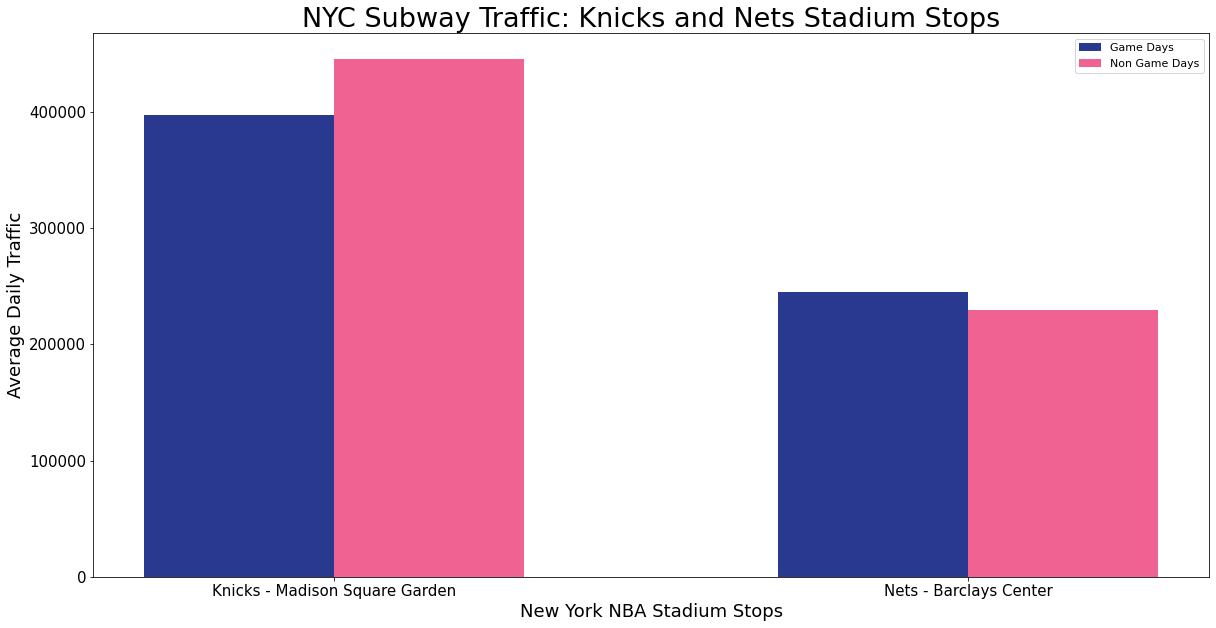

In [145]:
plt.bar(ind, nba_game_days, width, label='Game Days', color = '#2a3990')
plt.bar(ind + width, non_nba_game_days, width, label='Non Game Days', color = '#f06292')
plt.xlabel('New York NBA Stadium Stops', fontsize=18)
plt.ylabel('Average Daily Traffic', fontsize=18)
plt.title('NYC Subway Traffic: Knicks and Nets Stadium Stops', fontsize=27)
plt.legend()
plt.xticks(ind + width / 2, ('Knicks - Madison Square Garden', 'Nets - Barclays Center'), fontsize=15)
plt.yticks(fontsize=15)
plt.rcParams.update({'font.size': 11})
plt.savefig('nyc_nba_traffic.jpg');